# 2. DEVELOPMENT

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, pointbiserialr, kurtosis, skew
from phik import phik_matrix
import association_metrics as am
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, make_scorer, roc_curve, roc_auc_score, auc

## 2.1 Dataset - A first look

In this section, we will import the data and we'll take a first look.

In [2]:
df_raw = pd.read_csv("data/heart.csv", low_memory = False)

Dataset link: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data?select=heart.csv

In [3]:
df_raw.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
# Creating a copy of the original dataset
copy_df1 = df_raw.copy()

In [5]:
# Checking the number of unique values in every column
df_raw.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

Information about Features:
1. Age: Age of the patients (Years)
2. Sex: M: Male or F: Female
3. ChestPainType: TA: Typical Angina, ATA: Atypical Angina, NAP: Non Anginal Pain, ASY: Asymptomatic 
4. RestingBP: Resting systolic blood pressure (mm Hg)
5. Cholesterol: Cholesterol levels (mm/dl)
6. FastingBS: Fasting blood sugar (1: if FastingBS > 120 mg/dl, 0: otherwise)
7. RestingECG: Resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: Maximum heart rate achieved
9. ExerciseAngina: If angina originates from exercise or not (Y: Yes, N: No)
10. Oldpeak: ST depression included by exercise relative to rest
11. ST_Slope: The slope of the peak exercise St segment (UP: upsloping, Flat: flat, Down: downsloping)
12. HeartDisease: Target variable (1: heart disease, 0: Normal).


In [6]:
# A quick look at the dataframe
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


* There are no missing values in the dataset.
* We have some categorical features . We'll deal with them later.

## 2.2 A quick look into the features

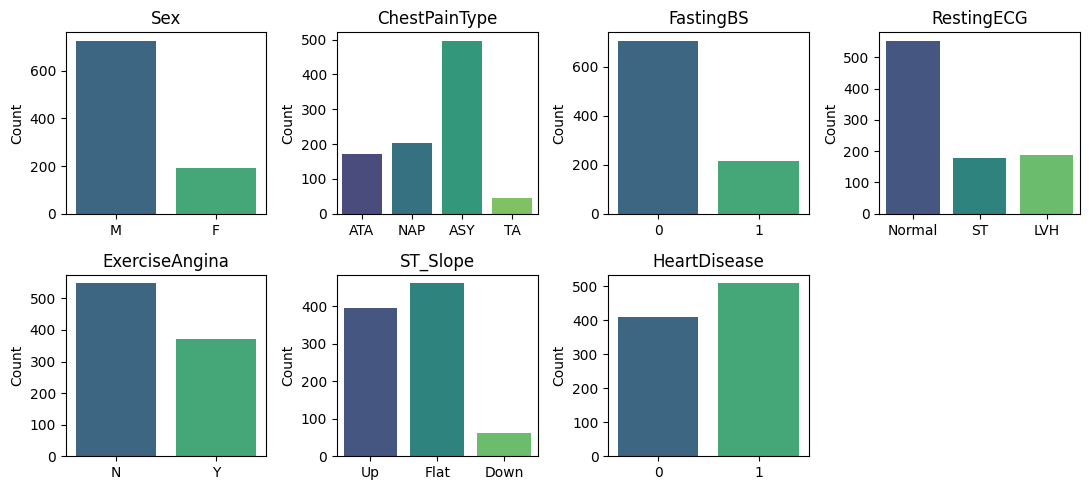

In [7]:
# Countplot for categorical features

categorical_feature_names = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']

# Create subplots dynamically based on the number of features
num_features = len(categorical_feature_names)
num_cols = 4
num_rows = -(-num_features // num_cols)  # Ceiling division

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(11, 2.5 * num_rows))

# Plot count plots for each categorical feature
for i, feature_name in enumerate(categorical_feature_names):
    row_idx = i // num_cols
    col_idx = i % num_cols
    sns.countplot(x=feature_name, data=df_raw, ax=axes[row_idx, col_idx], palette='viridis')
    
    axes[row_idx, col_idx].set_xlabel('')
    axes[row_idx, col_idx].set_ylabel('Count')
    axes[row_idx, col_idx].set_title(feature_name)
    axes[row_idx, col_idx].tick_params(axis='x', rotation=0)  # Rotate x-axis labels for better readability

# Remove empty subplots
for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

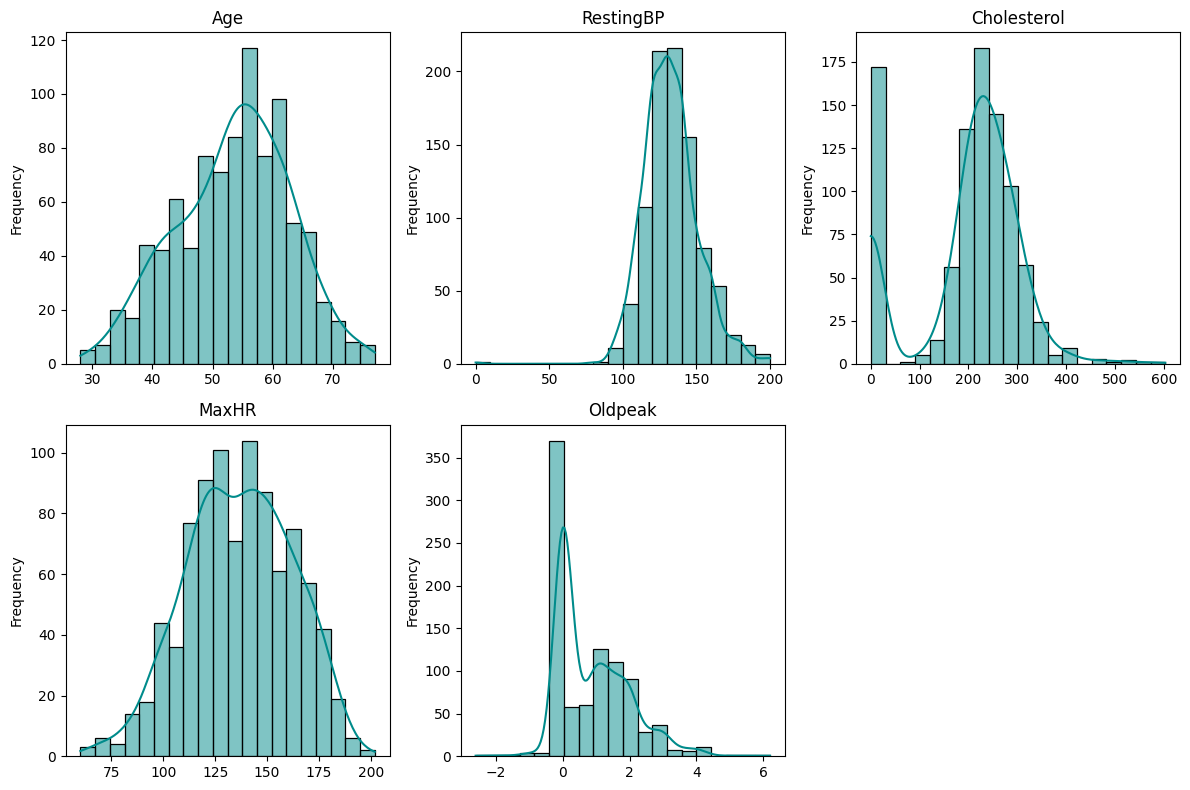

In [8]:
# Histogramm for numerical features

numerical_feature_names = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Create subplots dynamically based on the number of features
num_features_numerical = len(numerical_feature_names)
num_cols_numerical = 3
num_rows_numerical = -(-num_features_numerical // num_cols_numerical)  # Ceiling division

# Create subplots
fig, axes = plt.subplots(nrows=num_rows_numerical, ncols=num_cols_numerical, figsize=(12, 4 * num_rows_numerical))

# Plot histograms for each numerical feature
for i, feature_name_numerical in enumerate(numerical_feature_names):
    row_idx_numerical = i // num_cols_numerical
    col_idx_numerical = i % num_cols_numerical
    sns.histplot(df_raw[feature_name_numerical], kde=True, ax=axes[row_idx_numerical, col_idx_numerical], color='darkcyan', bins=20)
    
    axes[row_idx_numerical, col_idx_numerical].set_xlabel('')
    axes[row_idx_numerical, col_idx_numerical].set_ylabel('Frequency')
    axes[row_idx_numerical, col_idx_numerical].set_title(feature_name_numerical)

# Remove empty subplots
for i in range(num_features_numerical, num_rows_numerical * num_cols_numerical):
    fig.delaxes(axes.flatten()[i])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Important insights from the above graphs:
- We can detect some zero values in the "RestingBP" feature. Resting Blood Pressure cannot take zero value. 
- We can detect some zero values in the "Cholesterol" feature. Cholesterol cannot take zero value.
- The dataset is almost evenly balanced regarding the target variable, HeartDisease.

Further investigation of the zero values in “RestingBP”  and “Cholesterol”:

In [9]:
# Count zero values in "RestingBP" feature

zero_count_RestingBP = 0

for value in df_raw['RestingBP']:
    if value == 0:
        zero_count_RestingBP = zero_count_RestingBP + 1
        
print(f"The number of samples that have zero value in RestingBP is: {zero_count_RestingBP}")

The number of samples that have zero value in RestingBP is: 1


In [10]:
# Count zero values in "Cholesterol" feature

zero_count_Cholesterol = 0

for value in df_raw['Cholesterol']:
    if value == 0:
        zero_count_Cholesterol = zero_count_Cholesterol + 1
        
print(f"The number of samples that have zero value in Cholesterol is: {zero_count_Cholesterol}")

The number of samples that have zero value in Cholesterol is: 172


In [11]:
# Find how many of the zero "Cholesterol" samples have Heart Disease

zero_count_Cholesterol = 0
heart_disease_with_zero_chol = 0

for index, row in df_raw.iterrows():
    if row['Cholesterol'] == 0:
        zero_count_Cholesterol += 1
        if row['HeartDisease'] == 1:
            heart_disease_with_zero_chol += 1

print(f"The number of samples that have zero value in Cholesterol is: {zero_count_Cholesterol}")
print(f"Among these, the number of samples with HeartDisease equal to 1 is: {heart_disease_with_zero_chol}")

The number of samples that have zero value in Cholesterol is: 172
Among these, the number of samples with HeartDisease equal to 1 is: 152


So, we need to address these wrong zero values. We are going to treat them as missing values and remove them from the dataset.

## 2.3 Drop samples with missing values

There are two different strategies for handling missing or incorrect data: the first strategy is to simply ignore these values, and the second strategy is to consider imputation of these values. In this sub-section, we implement the first strategy by removing samples with incorrect zero values.

In [12]:
# Drop samples with zero values
df = df_raw.loc[df_raw['Cholesterol'] !=0].reset_index(drop=True)

# Information about the new dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             746 non-null    int64  
 1   Sex             746 non-null    object 
 2   ChestPainType   746 non-null    object 
 3   RestingBP       746 non-null    int64  
 4   Cholesterol     746 non-null    int64  
 5   FastingBS       746 non-null    int64  
 6   RestingECG      746 non-null    object 
 7   MaxHR           746 non-null    int64  
 8   ExerciseAngina  746 non-null    object 
 9   Oldpeak         746 non-null    float64
 10  ST_Slope        746 non-null    object 
 11  HeartDisease    746 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 70.1+ KB


In [13]:
# Checking if there are zero values in the new dataframe
zero_values_check = (df[['RestingBP', 'Cholesterol']] == 0).any()
print(zero_values_check)

RestingBP      False
Cholesterol    False
dtype: bool


In [14]:
# Checking for imbalance in the target variable after dropping the samples with missing values
HeartDisease_counts_ = df['HeartDisease'].value_counts()
print(HeartDisease_counts_)

0    390
1    356
Name: HeartDisease, dtype: int64


After removing the samples with incorrect zero values, we can observe that the target variable “HeartDisease” is still balanced.

## 2.4 Exploratory Data Analysis (EDA) & Outliers Handling

- In this section, we conduct a basic exploratory analysis in every feature and the target variable.

### 2.4.1 Exploration of "Age" feature

<Figure size 1000x1000 with 0 Axes>

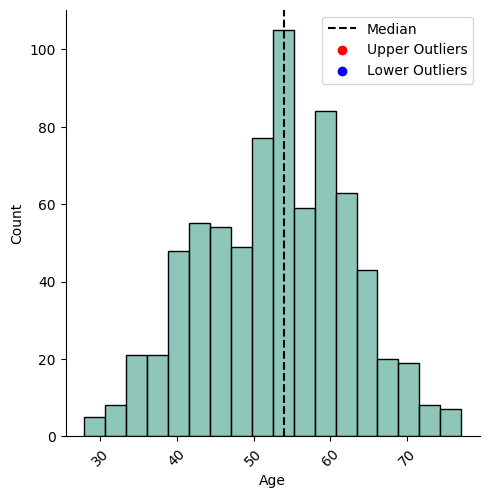

In [15]:
# Visualization of "Age"
plt.figure(figsize=(10, 10))
sns.displot(df["Age"], color='#69b3a2')

median = df["Age"].median()
plt.axvline(median, color='black', linestyle='--', label='Median')

iqr = df["Age"].quantile(0.75) - df["Age"].quantile(0.25)

# Calculate the upper and lower bounds for outliers
upper_bound = df["Age"].quantile(0.75) + 1.5 * iqr
lower_bound = df["Age"].quantile(0.25) - 1.5 * iqr

# Identify outliers above the upper bound
upper_outliers = df[df["Age"] > upper_bound]

# Identify outliers below the lower bound
lower_outliers = df[df["Age"] < lower_bound]

# Plot upper outliers as red marks and lower outliers as blue marks
plt.scatter(upper_outliers["Age"], [0] * len(upper_outliers), marker='o', color='red', label='Upper Outliers')
plt.scatter(lower_outliers["Age"], [0] * len(lower_outliers), marker='o', color='blue', label='Lower Outliers')

plt.legend()
plt.xticks(rotation=45)
plt.show()

In [16]:
# Descriptive statistics of "Age"
Age_description = df['Age'].describe().round(3)

# Distribution measures of "Age"
Age_kurtosis = round(kurtosis(df['Age']), 3)
Age_skewness = round(skew(df['Age']), 3)

# Create a simplified DataFrame with two columns
age_output = pd.DataFrame({
    "Statistic": ['Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max', 'Kurtosis', 'Skewness'],
    "Value": list(Age_description.values) + [Age_kurtosis, Age_skewness]
})

print(age_output.to_string(index=False, col_space=10))

 Statistic      Value
     Count    746.000
      Mean     52.882
       Std      9.506
       Min     28.000
       25%     46.000
       50%     54.000
       75%     59.000
       Max     77.000
  Kurtosis     -0.393
  Skewness     -0.103


* No outliers in the "Age" feature
* The distribution is approximately normal

### 2.4.2 Exploration of "Sex" feature

In [17]:
df['Sex'].unique()

array(['M', 'F'], dtype=object)

In [18]:
# Count number for each category
Sex_type_counts = df['Sex'].value_counts()
print(Sex_type_counts)

M    564
F    182
Name: Sex, dtype: int64


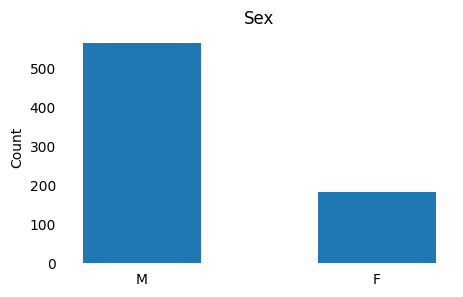

In [19]:
# Visualization of "Sex"
plt.figure(figsize=(5, 3))
plt.bar(Sex_type_counts.index, Sex_type_counts.values, width=0.5)
plt.xlabel('')
plt.ylabel('Count')
plt.title('Sex')
plt.box(False)
plt.tick_params(axis='both', which='both', bottom=False, left=False)
plt.show()

In [20]:
# Calculate percetanges
Sex_type_counts_as_percentage = df['Sex'].value_counts(True)*100
print(Sex_type_counts_as_percentage)

M    75.603217
F    24.396783
Name: Sex, dtype: float64


* The males in this dataset account for 75.60%, while the females account for 24.39%

### 2.4.3 Exploration of "ChestPainType" feature

In [21]:
df['ChestPainType'].unique()

array(['ATA', 'NAP', 'ASY', 'TA'], dtype=object)

In [22]:
# Count number for each category
ChestPainType_counts = df['ChestPainType'].value_counts()
print(ChestPainType_counts)

ASY    370
NAP    169
ATA    166
TA      41
Name: ChestPainType, dtype: int64


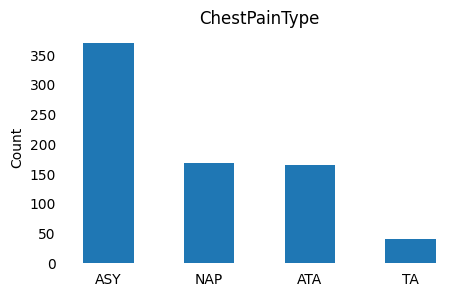

In [23]:
# Visualization of "ChestPainType"
plt.figure(figsize=(5, 3))
plt.bar(ChestPainType_counts.index, ChestPainType_counts.values, width=0.5)
plt.xlabel('')
plt.ylabel('Count')
plt.title('ChestPainType')
plt.box(False)
plt.tick_params(axis='both', which='both', bottom=False, left=False)
plt.show()

In [24]:
# Calculate percetanges
ChestPainType_counts_as_percentage = df['ChestPainType'].value_counts(True)*100
print(ChestPainType_counts_as_percentage)

ASY    49.597855
NAP    22.654155
ATA    22.252011
TA      5.495979
Name: ChestPainType, dtype: float64


* The majority (49.59%) of individuals are Asymptomatic, while the minority (5.49%) have Typical Angina. 

### 2.4.4 Exploration of "RestingBP" feature

<Figure size 1000x1000 with 0 Axes>

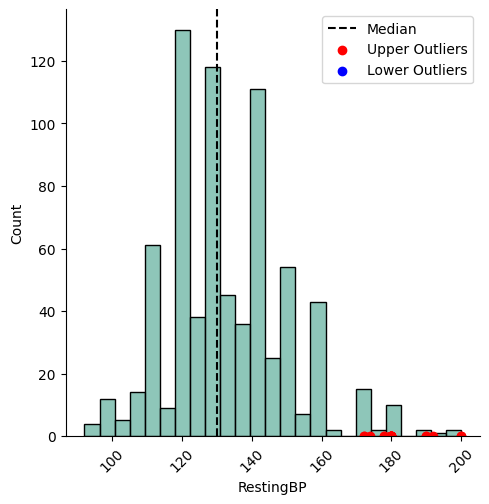

In [25]:
# Visualization of "RestingBP"
plt.figure(figsize=(10, 10))
sns.displot(df["RestingBP"], color='#69b3a2')

median = df["RestingBP"].median()
plt.axvline(median, color='black', linestyle='--', label='Median')

iqr = df["RestingBP"].quantile(0.75) - df["RestingBP"].quantile(0.25)

# Calculate the upper and lower bounds for outliers
upper_bound = df["RestingBP"].quantile(0.75) + 1.5 * iqr
lower_bound = df["RestingBP"].quantile(0.25) - 1.5 * iqr

# Identify outliers above the upper bound
upper_outliers = df[df["RestingBP"] > upper_bound]

# Identify outliers below the lower bound
lower_outliers = df[df["RestingBP"] < lower_bound]

# Plot upper outliers as red marks and lower outliers as blue marks
plt.scatter(upper_outliers["RestingBP"], [0] * len(upper_outliers), marker='o', color='red', label='Upper Outliers')
plt.scatter(lower_outliers["RestingBP"], [0] * len(lower_outliers), marker='o', color='blue', label='Lower Outliers')

plt.legend()
plt.xticks(rotation=45)
plt.show()

In [26]:
# Descriptive statistics of "RestingBP"
RestingBP_description = df['RestingBP'].describe().round(3)

# Distribution measures of "Age"
RestingBP_kurtosis = round(kurtosis(df['RestingBP']), 3)
RestingBP_skewness = round(skew(df['RestingBP']), 3)

# Create a simplified DataFrame with two columns
RestingBP_output = pd.DataFrame({
    "Statistic": ['Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max', 'Kurtosis', 'Skewness'],
    "Value": list(RestingBP_description.values) + [RestingBP_kurtosis, RestingBP_skewness]
})

print(RestingBP_output.to_string(index=False, col_space=10))

 Statistic      Value
     Count    746.000
      Mean    133.023
       Std     17.283
       Min     92.000
       25%    120.000
       50%    130.000
       75%    140.000
       Max    200.000
  Kurtosis      0.730
  Skewness      0.619


- We can detect some upper-bound outliers in the "RestingBP" feature.
- The distribution of RestingBP is appoximately normal

### 2.4.5 Exploration of "Cholesterol" feature

<Figure size 1000x1000 with 0 Axes>

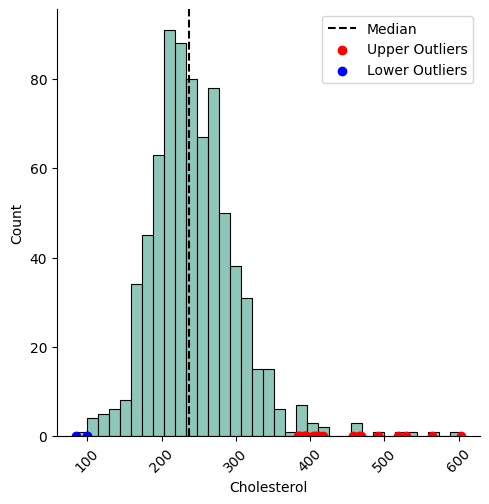

In [27]:
# Visualization of "Cholesterol"
plt.figure(figsize=(10, 10))
sns.displot(df["Cholesterol"], color='#69b3a2')

median = df["Cholesterol"].median()
plt.axvline(median, color='black', linestyle='--', label='Median')

iqr = df["Cholesterol"].quantile(0.75) - df["Cholesterol"].quantile(0.25)

# Calculate the upper and lower bounds for outliers
upper_bound = df["Cholesterol"].quantile(0.75) + 1.5 * iqr
lower_bound = df["Cholesterol"].quantile(0.25) - 1.5 * iqr

# Identify outliers above the upper bound
upper_outliers = df[df["Cholesterol"] > upper_bound]

# Identify outliers below the lower bound
lower_outliers = df[df["Cholesterol"] < lower_bound]

# Plot upper outliers as red marks and lower outliers as blue marks
plt.scatter(upper_outliers["Cholesterol"], [0] * len(upper_outliers), marker='o', color='red', label='Upper Outliers')
plt.scatter(lower_outliers["Cholesterol"], [0] * len(lower_outliers), marker='o', color='blue', label='Lower Outliers')

plt.legend()
plt.xticks(rotation=45)
plt.show()

In [28]:
# Descriptive statistics of "Cholesterol"
Cholesterol_description = df['Cholesterol'].describe().round(3)

# Distribution measures of "Age"
Cholesterol_kurtosis = round(kurtosis(df['Cholesterol']), 3)
Cholesterol_skewness = round(skew(df['Cholesterol']), 3)

# Create a simplified DataFrame with two columns
Cholesterol_output = pd.DataFrame({
    "Statistic": ['Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max', 'Kurtosis', 'Skewness'],
    "Value": list(Cholesterol_description.values) + [Cholesterol_kurtosis, Cholesterol_skewness]
})

print(Cholesterol_output.to_string(index=False, col_space=10))

 Statistic      Value
     Count    746.000
      Mean    244.635
       Std     59.154
       Min     85.000
       25%    207.250
       50%    237.000
       75%    275.000
       Max    603.000
  Kurtosis      4.490
  Skewness      1.236


- We can detect some outliers in the "Cholesterol" feature.
- The distribution is right skewed.

### 2.4.6 Exploration of "FastingBS" feature

In [29]:
df['FastingBS'].unique()

array([0, 1], dtype=int64)

In [30]:
# Count number for each category
FastingBS_counts = df['FastingBS'].value_counts()
print(FastingBS_counts)

0    621
1    125
Name: FastingBS, dtype: int64


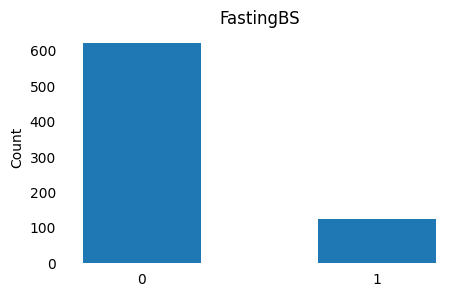

In [31]:
# Visualization of "FastingBS"
plt.figure(figsize=(5, 3))
plt.bar(FastingBS_counts.index, FastingBS_counts.values, width=0.5)
plt.xlabel('')
plt.ylabel('Count')
plt.title('FastingBS')
plt.box(False)
plt.tick_params(axis='both', which='both', bottom=False, left=False)
plt.xticks([0, 1])
plt.show()

In [32]:
# Calculate percetanges
FastingBS_counts_as_percentage = df['FastingBS'].value_counts(True)*100
print(FastingBS_counts_as_percentage)

0    83.243968
1    16.756032
Name: FastingBS, dtype: float64


* Fasting blood sugar levels below 120 mg/dL account for 83.24%, while levels below 120 mg/dL account for 16.75%.

### 2.4.7 Exploration of "RestingECG" feature

In [33]:
df['RestingECG'].unique()

array(['Normal', 'ST', 'LVH'], dtype=object)

In [34]:
# Count number for each category
RestingECG_counts = df['RestingECG'].value_counts()
print(RestingECG_counts)

Normal    445
LVH       176
ST        125
Name: RestingECG, dtype: int64


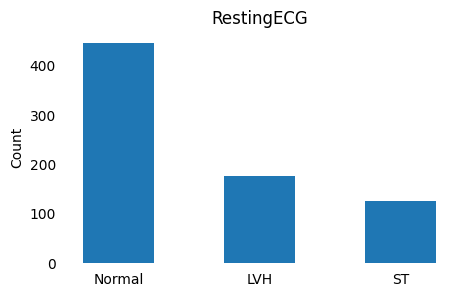

In [35]:
# Visualization of "RestingECG"
plt.figure(figsize=(5, 3))
plt.bar(RestingECG_counts.index, RestingECG_counts.values, width=0.5)
plt.xlabel('')
plt.ylabel('Count')
plt.title('RestingECG')
plt.box(False)
plt.tick_params(axis='both', which='both', bottom=False, left=False)
plt.show()

In [36]:
# Calculate percetanges
RestingECG_counts_as_percentage = df['RestingECG'].value_counts(True)*100
print(RestingECG_counts_as_percentage)

Normal    59.651475
LVH       23.592493
ST        16.756032
Name: RestingECG, dtype: float64


- The majority (59.65%) of individuals have Normal RestingECG. The others have either LVH or ST.

### 2.4.8 Exploration of "MaxHR" feature

<Figure size 1000x1000 with 0 Axes>

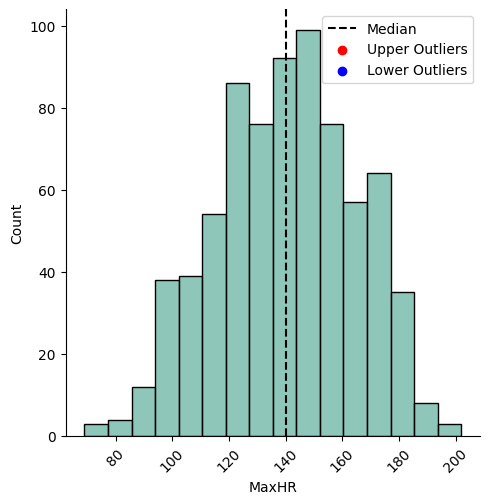

In [37]:
# Visualization of "MaxHR"
plt.figure(figsize=(10, 10))
sns.displot(df["MaxHR"], color='#69b3a2')

median = df["MaxHR"].median()
plt.axvline(median, color='black', linestyle='--', label='Median')

iqr = df["MaxHR"].quantile(0.75) - df["MaxHR"].quantile(0.25)

# Calculate the upper and lower bounds for outliers
upper_bound = df["MaxHR"].quantile(0.75) + 1.5 * iqr
lower_bound = df["MaxHR"].quantile(0.25) - 1.5 * iqr

# Identify outliers above the upper bound
upper_outliers = df[df["MaxHR"] > upper_bound]

# Identify outliers below the lower bound
lower_outliers = df[df["MaxHR"] < lower_bound]

# Plot upper outliers as red marks and lower outliers as blue marks
plt.scatter(upper_outliers["MaxHR"], [0] * len(upper_outliers), marker='o', color='red', label='Upper Outliers')
plt.scatter(lower_outliers["MaxHR"], [0] * len(lower_outliers), marker='o', color='blue', label='Lower Outliers')

plt.legend()
plt.xticks(rotation=45)
plt.show()

In [38]:
# Descriptive statistics of "MaxHR"
MaxHR_description = df['MaxHR'].describe().round(3)

# Distribution measures of "Age"
MaxHR_kurtosis = round(kurtosis(df['MaxHR']), 3)
MaxHR_skewness = round(skew(df['MaxHR']), 3)

# Create a simplified DataFrame with two columns
MaxHR_output = pd.DataFrame({
    "Statistic": ['Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max', 'Kurtosis', 'Skewness'],
    "Value": list(MaxHR_description.values) + [MaxHR_kurtosis, MaxHR_skewness]
})

print(MaxHR_output.to_string(index=False, col_space=10))

 Statistic      Value
     Count    746.000
      Mean    140.227
       Std     24.524
       Min     69.000
       25%    122.000
       50%    140.000
       75%    160.000
       Max    202.000
  Kurtosis     -0.557
  Skewness     -0.165


- The "MaxHR" feature follows approximately a normal distribution, with no outliers.

### 2.4.9 Exploration of "ExerciseAngina" feature

In [39]:
df['ExerciseAngina'].unique()

array(['N', 'Y'], dtype=object)

In [40]:
# Count number for each category
ExerciseAngina_counts = df['ExerciseAngina'].value_counts()
print(ExerciseAngina_counts)

N    459
Y    287
Name: ExerciseAngina, dtype: int64


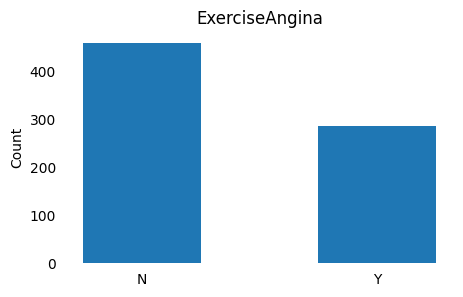

In [41]:
# Visualization of "ExerciseAngina"
plt.figure(figsize=(5, 3))
plt.bar(ExerciseAngina_counts.index, ExerciseAngina_counts.values, width=0.5)
plt.xlabel('')
plt.ylabel('Count')
plt.title('ExerciseAngina')
plt.box(False)
plt.tick_params(axis='both', which='both', bottom=False, left=False)
plt.show()

In [42]:
# Calculate percetanges
ExerciseAngina_counts_as_percentage = df['ExerciseAngina'].value_counts(True)*100
print(ExerciseAngina_counts_as_percentage)

N    61.52815
Y    38.47185
Name: ExerciseAngina, dtype: float64


- 38.47% of individuals get angina from exercise, while 61.52% do not.

### 2.4.10 Exploration of "Oldpeak" feature

In [43]:
df['Oldpeak'].unique()

array([ 0. ,  1. ,  1.5,  2. ,  3. ,  4. ,  0.5,  2.5,  5. ,  0.8,  1.3,
        1.6,  1.2,  1.9,  1.7,  0.1,  0.4,  0.3,  0.2, -0.1,  1.4,  1.1,
        1.8,  3.5,  2.4,  0.6,  2.6,  3.1,  2.3,  3.4,  0.9,  2.2,  3.6,
        4.2,  3.2,  0.7,  5.6,  3.8,  2.1,  2.9,  2.8,  6.2,  4.4])

<Figure size 1000x1000 with 0 Axes>

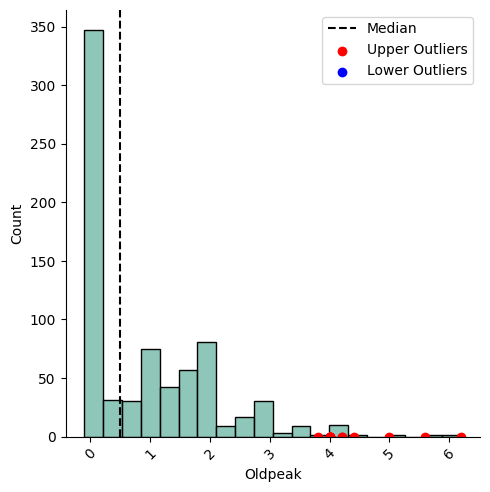

In [44]:
# Visualization of "Oldpeak"
plt.figure(figsize=(10, 10))
sns.displot(df["Oldpeak"], color='#69b3a2')

median = df["Oldpeak"].median()
plt.axvline(median, color='black', linestyle='--', label='Median')

iqr = df["Oldpeak"].quantile(0.75) - df["Oldpeak"].quantile(0.25)

# Calculate the upper and lower bounds for outliers
upper_bound = df["Oldpeak"].quantile(0.75) + 1.5 * iqr
lower_bound = df["Oldpeak"].quantile(0.25) - 1.5 * iqr

# Identify outliers above the upper bound
upper_outliers = df[df["Oldpeak"] > upper_bound]

# Identify outliers below the lower bound
lower_outliers = df[df["Oldpeak"] < lower_bound]

# Plot upper outliers as red marks and lower outliers as blue marks
plt.scatter(upper_outliers["Oldpeak"], [0] * len(upper_outliers), marker='o', color='red', label='Upper Outliers')
plt.scatter(lower_outliers["Oldpeak"], [0] * len(lower_outliers), marker='o', color='blue', label='Lower Outliers')

plt.legend()
plt.xticks(rotation=45)
plt.show()

In [45]:
# Descriptive statistics of "Oldpeak"
Oldpeak_description = df['Oldpeak'].describe().round(3)

# Distribution measures of "Age"
Oldpeak_kurtosis = round(kurtosis(df['Oldpeak']), 3)
Oldpeak_skewness = round(skew(df['Oldpeak']), 3)

# Create a simplified DataFrame with two columns
Oldpeak_output = pd.DataFrame({
    "Statistic": ['Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max', 'Kurtosis', 'Skewness'],
    "Value": list(Oldpeak_description.values) + [Oldpeak_kurtosis, Oldpeak_skewness]
})

print(Oldpeak_output.to_string(index=False, col_space=10))

 Statistic      Value
     Count    746.000
      Mean      0.902
       Std      1.073
       Min     -0.100
       25%      0.000
       50%      0.500
       75%      1.500
       Max      6.200
  Kurtosis      1.345
  Skewness      1.217


- We can detect some upper bound outliers in the Oldpeak feature. The distribution is right skewed.

### 2.4.11 Exploration of "ST_Slope" feature

In [46]:
df['ST_Slope'].unique()

array(['Up', 'Flat', 'Down'], dtype=object)

In [47]:
# Count number for each category
ST_Slope_counts = df['ST_Slope'].value_counts()
print(ST_Slope_counts)

Flat    354
Up      349
Down     43
Name: ST_Slope, dtype: int64


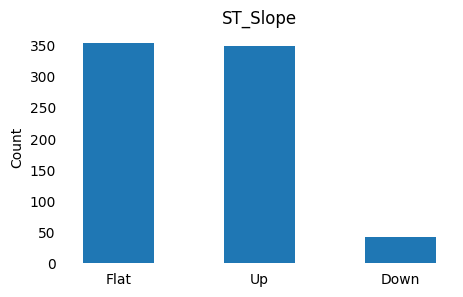

In [48]:
# Visualization of "ST_Slope"
plt.figure(figsize=(5, 3))
plt.bar(ST_Slope_counts.index, ST_Slope_counts.values, width=0.5)
plt.xlabel('')
plt.ylabel('Count')
plt.title('ST_Slope')
plt.box(False)
plt.tick_params(axis='both', which='both', bottom=False, left=False)
plt.show()

In [49]:
# Calculate percetanges
ST_Slope_counts_as_percentage = df['ST_Slope'].value_counts(True)*100
print(ST_Slope_counts_as_percentage)

Flat    47.453083
Up      46.782842
Down     5.764075
Name: ST_Slope, dtype: float64


- The minority of individuals (5.76%) display a downward or negative slope in the ST segment during peak exercise. The rest exhibit an Upward or Flat slope.

### 2.4.12 Exploration of "HeartDisease" feature (Target Variable)

In [50]:
df['HeartDisease'].unique()

array([0, 1], dtype=int64)

In [51]:
# Count number for each category
HeartDisease_counts = df['HeartDisease'].value_counts()
print(HeartDisease_counts)

0    390
1    356
Name: HeartDisease, dtype: int64


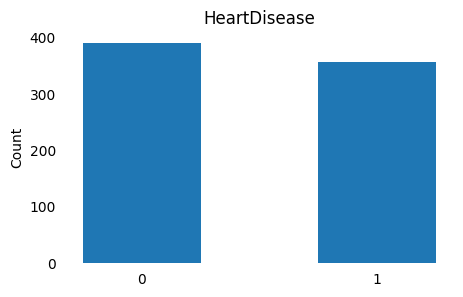

In [52]:
# Visualization of "HeartDisease"
plt.figure(figsize=(5, 3))
plt.bar(HeartDisease_counts.index, HeartDisease_counts.values, width=0.5)
plt.xlabel('')
plt.ylabel('Count')
plt.title('HeartDisease')
plt.box(False)
plt.tick_params(axis='both', which='both', bottom=False, left=False)
plt.xticks([0, 1])
plt.show()

In [53]:
# Calculate percetanges
HeartDisease_counts_as_percentage = df['HeartDisease'].value_counts(True)*100
print(HeartDisease_counts_as_percentage)

0    52.27882
1    47.72118
Name: HeartDisease, dtype: float64


- The dataset is nearly evenly balanced concerning the target variable. Specifically, 47.72% of the individuals have some form of Heart Disease, while 52.28% do not.

### 2.4.13 Summary of EDA

After we concluded the Exploration Analysis of the features, we found out:
- 1. The "Age" feature follows an approximately normal distribution with no outliers.
- 2. Regarding the "Sex" feature, males account for 76%, while females account for 24%.
- 3. Regarding the "ChestPainType" almost half of the patients (50%) are asymptomatic. The others have some kind of chestpain.
- 4. The distribution of "RestingBP" is approximately normal. We can detect some upper bound outliers.
- 5. The distribution of " Cholesterol" is right skewed. We can detect some outliers, mostly upper bound.
- 6. "FastingBS" levels below 120 mg/dL account for 83%, while levels above 120 mg/dL account for 17%.
- 7. Regarding the "RestingECG", we see that the majority (60%) has a Normal value.
- 8. The "MaxHR" feature follows an approximately normal distribution with no outliers.
- 9. Regarding the "ExerciseAngina" feature, 62% of the peoples angina originates from exercise , while 38% does not.
- 10. We can detect some upper bound outliers in the Oldpeak feature.
- 11. Regarding the "ST_Slope" feature, only 5,76% have down value. The others have Flat or Up values.
- 12. The dataset is almost evenly balanced regarding the target variable (HeartDisease)

## 2.5. Comparative Statistics & Correlations

### 2.5.1 Analysis of numerical features against HeartDisease

- Let's explore how the numeric variables relate to the occurrence of a Heart Disease, which is our target variable. 
- Analyzing the relationship between the numeric variables and Heart Disease can provide insights into their impact on Heart Disease occurrence.

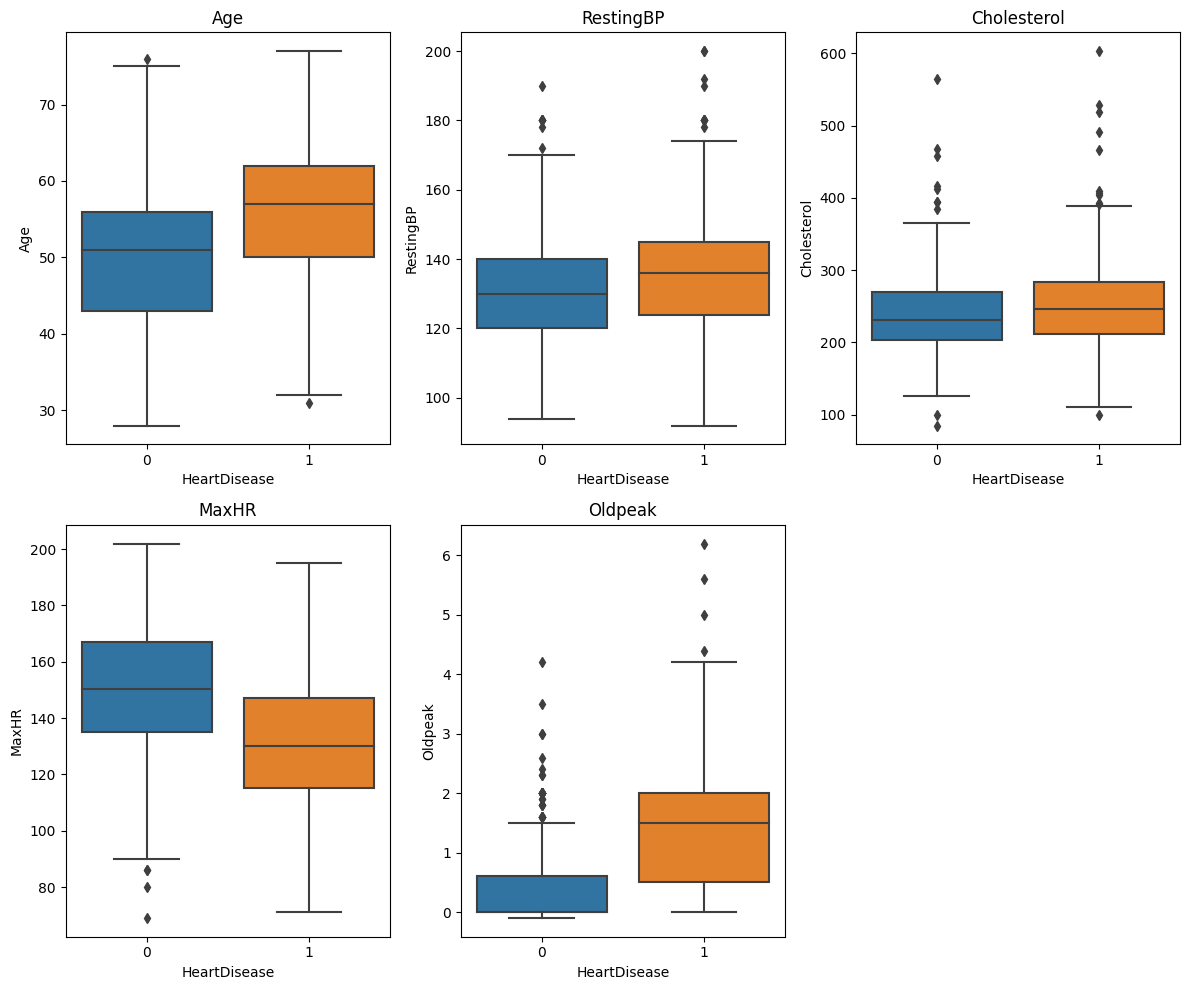

In [54]:
# Visualization of numeric features vs Target Variable (HeartDisease)

fig, axes = plt.subplots(2, 3, figsize=(12, 10))

# Boxplot Age vs HeartDisease
sns.boxplot(data=df, x='HeartDisease', y='Age', ax=axes[0,0])
axes[0,0].set_title("Age")

# Boxplot RestingBP vs HeartDisease
sns.boxplot(data=df, x='HeartDisease', y='RestingBP', ax=axes[0,1])
axes[0,1].set_title("RestingBP")

# Boxplot Cholesterol vs HeartDisease
sns.boxplot(data=df, x='HeartDisease', y='Cholesterol', ax=axes[0,2])
axes[0,2].set_title("Cholesterol")

# Boxplot MaxHR vs HeartDisease
sns.boxplot(data=df, x='HeartDisease', y='MaxHR', ax=axes[1,0])
axes[1,0].set_title("MaxHR")

# Boxplot Oldpeak vs HeartDisease
sns.boxplot(data=df, x='HeartDisease', y='Oldpeak', ax=axes[1,1])
axes[1,1].set_title("Oldpeak")

plt.delaxes(axes[1, 2])  # Remove the last subplot in the second row

plt.tight_layout()

* The risk of Heart Disease rises as individuals grow older.
* RestingBP appear to slightly influence the occurrence of a Heart Disease.
* Cholesterol appears to have a slight influence on the occurrence of heart disease. Individuals with higher cholesterol values seem to have a greater chance of developing heart disease.
* The risk of Heart Disease increases as the Max Heart Rate decreases.
* As Oldpeak values increase, the risk of Heart Disease rises.

### 2.5.2 Pairwise Correlations between numerical continuous features - Pearson Correlation

In this sub-section, we are going to examine the correlations between the numerical features. 

Correlation coefficients describe the strength and direction of the association between numerical variables. The Pearson correlation coefficient (r) specifically measures the degree of linear association between two numerical variables. Pearson’s r values range from -1 to 1, where values close to 1 indicate a strong positive linear relationship, values close to -1 indicate a strong negative linear relationship, and a value of 0 suggests no linear relationship

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             746 non-null    int64  
 1   Sex             746 non-null    object 
 2   ChestPainType   746 non-null    object 
 3   RestingBP       746 non-null    int64  
 4   Cholesterol     746 non-null    int64  
 5   FastingBS       746 non-null    int64  
 6   RestingECG      746 non-null    object 
 7   MaxHR           746 non-null    int64  
 8   ExerciseAngina  746 non-null    object 
 9   Oldpeak         746 non-null    float64
 10  ST_Slope        746 non-null    object 
 11  HeartDisease    746 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 70.1+ KB


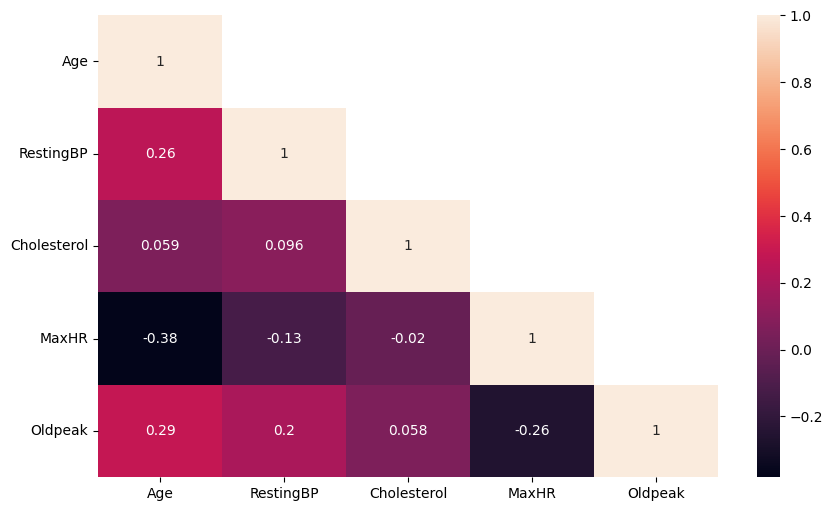

In [56]:
# Correlations of numerical continuous features

# Excluding categorical and binary features from the Heatmap
df_numeric = df.drop(['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope','HeartDisease'], axis=1)

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

plt.figure(figsize=(10, 6))
ax = sns.heatmap(correlation_matrix, annot=True, cbar_kws={'orientation': 'vertical'}, cbar=True, mask=mask)

# Rotate the y-axis tick labels to be horizontal
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.show()

* From this graph, we can see that there is no multicollinearity issue. None of the variable pairs exhibit a very high correlation.

### 2.5.3 Feature Importance for numerical features

In this subsection, our aim is to identify correlations between numerical-continuous features and heart disease to gain insights regarding feature importance. First, we are going to examine the significance of the numerical features. Second, we are going to explore the correlations between the numerical features and heart disease.In this sub-section, our aim is to identify correlations between numerical-continuous features and Heart Disease to gain insights regarding feature importance.

Statistical Significance - ANOVA F Test
- The p-values gives the probability of observing the calculated F-statistic, or more extreme values, under the assumption that the null hypothesis is true. The null hypothesis states that there is no significant difference among the group means (no association between the feature and the target variable).

In [57]:
# ANOVA F Test

# Excluding categorical and binary features from the Heatmap
df_numeric_target_variable_anova = df.drop(['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease'], axis=1) 

# Assuming df_numeric_target_variable contains the relevant numeric features and 'HeartDisease'
X = df_numeric_target_variable_anova
y = df['HeartDisease']

# Use SelectKBest with f_classif (you can use a different score function based on your data type)
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

# Get the scores and p-values of each feature
scores = selector.scores_
p_values = selector.pvalues_

# Create a DataFrame to store feature names, scores, and p-values
feature_scores = pd.DataFrame({'Feature': X.columns, 'F-Score': scores, 'P-Value': p_values})

# Sort features by score in descending order
feature_scores = feature_scores.sort_values(by='F-Score', ascending=False)

# Round the scores and p-values to six decimal places
feature_scores['F-Score'] = feature_scores['F-Score'].round(6)
feature_scores['P-Value'] = feature_scores['P-Value'].round(6)

# Display the feature scores and p-values
print(feature_scores.to_string(index=False))

    Feature    F-Score  P-Value
    Oldpeak 242.364279 0.000000
      MaxHR 123.425078 0.000000
        Age  72.839116 0.000000
  RestingBP  23.020309 0.000002
Cholesterol   8.113851 0.004514


We can see that all p-values are very close to zero, so we can conclude that each feature is statistically significant at both the 5% and 1% significance levels. The extremely low p-values indicate strong evidence against the null hypothesis, supporting the idea that these features are associated with the occurrence of Heart Disease.

Feature Importance – Point Biserial Correlation
- Point biserial correlation describes the correlation between a binary variable and a continuous variable. In this instance, our objective is to evaluate the correlation of each feature with the target variable, Heart Disease, providing valuable insights into feature importance.

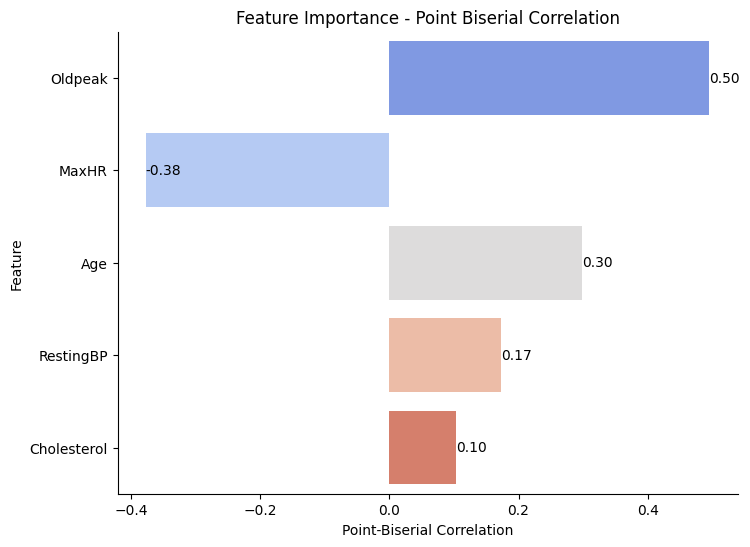

In [58]:
# Feature importance Correlation of numeric variables against HeartDisease - Point Biserial Correlation

# Excluding categorical and binary features
df_numeric_target_variable= df.drop(['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], axis=1)

# Calculate the point-biserial correlation with the target variable
biserial_correlations = {}
target_variable = df['HeartDisease']

for column in df_numeric_target_variable.columns:
    correlation, _ = pointbiserialr(df_numeric_target_variable[column], target_variable)
    biserial_correlations[column] = correlation

# Remove 'HeartDisease' from the correlations
biserial_correlations.pop('HeartDisease', None)

# Create a DataFrame with the correlations
correlation_df = pd.DataFrame(list(biserial_correlations.items()), columns=['Feature', 'Point-Biserial Correlation'])

# Sort the DataFrame by absolute correlation values
correlation_df = correlation_df.reindex(correlation_df['Point-Biserial Correlation'].abs().sort_values(ascending=False).index)

# Plotting with annotations
plt.figure(figsize=(8, 6))
sns.barplot(x='Point-Biserial Correlation', y='Feature', data=correlation_df, palette='coolwarm')

# Despine the plot
sns.despine()

# Add annotations
for index, value in enumerate(correlation_df['Point-Biserial Correlation']):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center', color='black')

plt.title('Feature Importance - Point Biserial Correlation')
plt.show()

We see that:
- Oldpeak exhibits the strongest positive correlation with HeartDisease, as observed from both the boxplot and the heatmap,  followed by Age.
- Cholesterol has the lowest positive correlation with HeartDisease.
- MaxHR have negative correlation with HeartDisease.

Furthermore, these correlations offer insights that align with those derived from Anova F-Scores, as well as observations from the box plot examination.

In [59]:
# # Feature importance Correlation of numeric variables against HeartDisease - Pearson's r (cross check - same results)

# # Excluding categorical and binary features from the Heatmap
# df_numeric_target_variable = df.drop(['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], axis=1) 

# # Calculate the correlation with the target variable
# correlations = df_numeric_target_variable.corrwith(df['HeartDisease']).sort_values(ascending=False)

# # Remove 'HeartDisease' from the correlations
# correlations = correlations.drop('HeartDisease')

# # Create a DataFrame with the correlations
# correlation_df = pd.DataFrame(correlations, columns=['Correlation with HeartDisease'])

# plt.figure(figsize=(6, 4))
# sns.heatmap(correlation_df, annot=True, cmap='coolwarm', cbar=False)
# plt.title('Feature Importance - Pearson Correlation')
# plt.show()

### 2.5.4 Analysis of Categorical Features against HeartDisease

In this sub-section we explore how the categorical variables relate to the occurrence of a Heart Disease, which is our target variable. Analyzing the relationship between the categorical variables and Heart Disease can provide insights into their impact on Heart Disease occurrence.

"FastingBS" is a binary variable that takes values of 0 and 1. We'll treat it as a categorical variable.

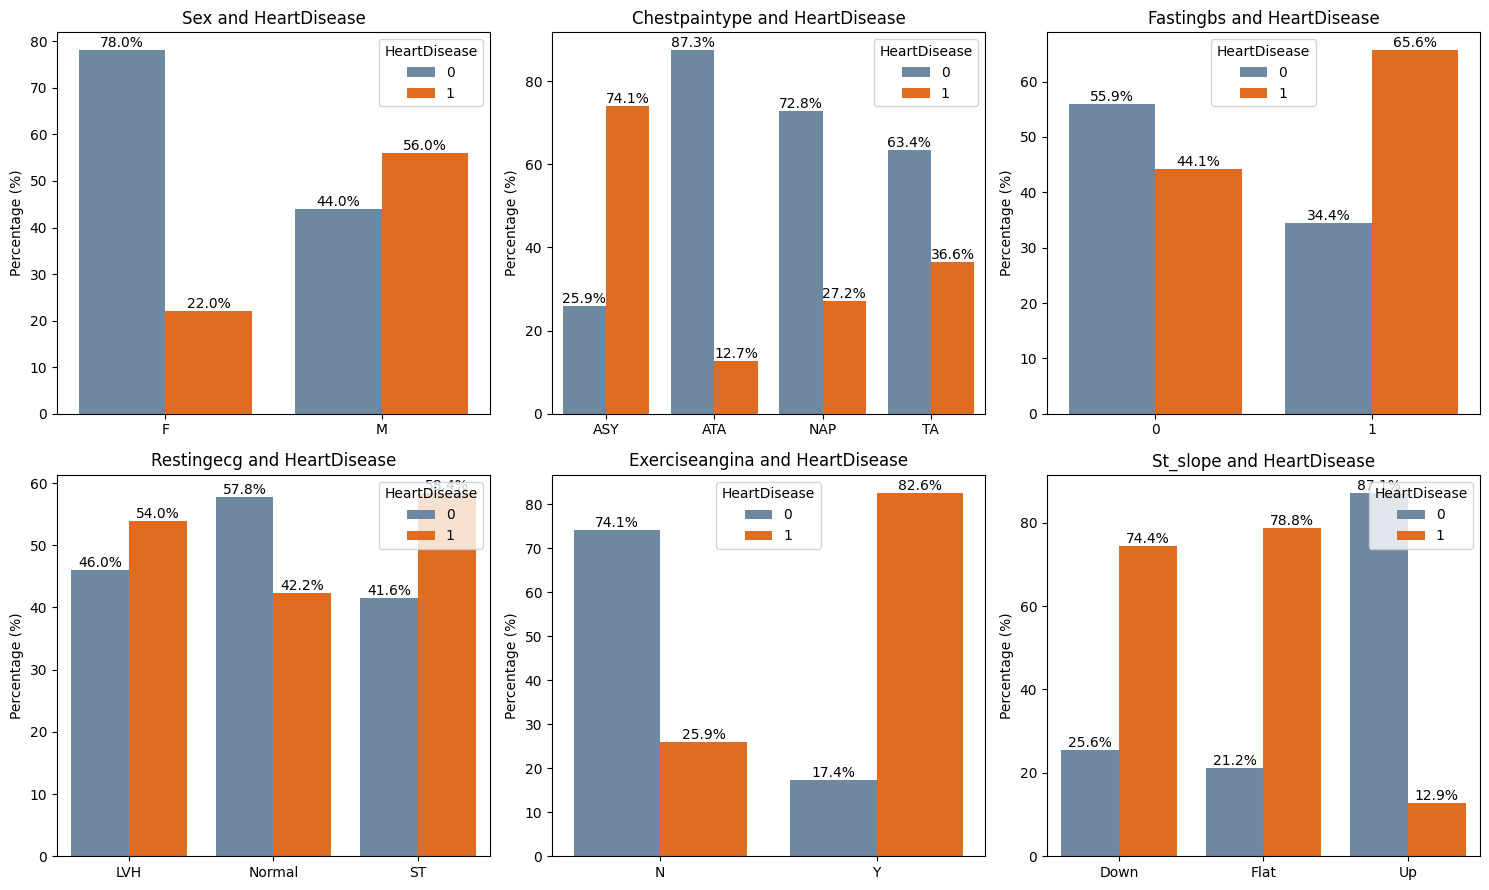

In [60]:
# Visualization of categorical features agains target variable
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 9))

# Flatten the axes array
axes = axes.flatten()

# Select categorical and binary features
variables = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina','ST_Slope']

# Iterate over the variables
for i, variable in enumerate(variables):
    # Calculate the count column
    grouped_df = df.groupby([variable, 'HeartDisease']).size().reset_index(name='count')

    # Calculate the percentages
    grouped_df['percentage'] = grouped_df.groupby(variable, group_keys=False)['count'].apply(lambda x: (x / x.sum()) * 100)

    # Plot the barplot
    sns.barplot(x=variable, y='percentage', hue='HeartDisease', data=grouped_df, palette={0: '#6688AA', 1: '#FF6600'}, ax=axes[i])
    axes[i].set_title(f'{variable.capitalize()} and HeartDisease')
    axes[i].set_ylabel('Percentage (%)')

    # Add percentage labels inside bars
    for p in axes[i].patches:
        percentage = '{:.1f}%'.format(p.get_height())
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        axes[i].annotate(percentage, (x, y), ha='center', va='bottom')

    # Remove x-axis title
    axes[i].set_xlabel('')

# Remove unnecessary subplots
if len(variables) < len(axes):
    for j in range(len(variables), len(axes)):
        fig.delaxes(axes[j])

# Adjust layout
fig.tight_layout()

Information about the graph:
- The above graph, shows the percentages of Heart Disease and no Heart Disease per value and not per total patients. For example, females who din't have a Heart Disease account for 78% of all FEMALES (not all individuals). This way we can gain some insights into which variable plays an significant role in the occurrence of a Heart Disease. Now that we have clarified that, we continue with the analysis.

Insights:
- The majority of females (78%) do not have heart disease, while the majority of males (56%) do have heart disease.
- Surprisingly, when it comes to "ChestPainType," 74.1% of patients with Asymptomatic chest pain have heart disease.
- It's noteworthy that 65.6% of individuals with fasting blood sugar levels > 120 mg/dL have heart disease. Fasting blood sugar levels appear to play a role in the occurrence of heart disease.
- Individuals without Normal value in  Resting Electrocardiogram Results tend to have Heart Disease
- It's evident that patients with angina originating from exercise have a significantly higher prevalence of heart disease (82.6%) compared to those with angina not originating from exercise, where only 25.9% have heart disease. This suggests that the nature of angina symptoms can be an important indicator of heart disease risk.
- The majority of individuals with an upsloping ST slope do not have heart disease. In contrast, the majority of those with a downsloping or flat ST slope do have heart disease.

### 2.5.5 Examination of Pairwise Correlations for Categorical Features - Cramer's V

Cramer's V is a statistic used to measure the strength of association between two categorical variables. It is an extension of the chi-squared statistic and is commonly used to assess the degree of dependence or correlation between two categorical features in a contingency table. Cramer's V values range between 0 and 1, with higher values indicating a stronger association.

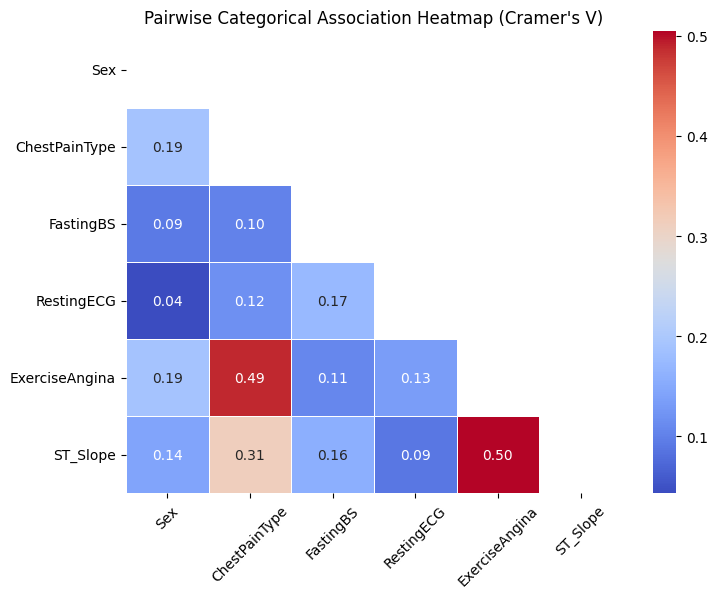

In [61]:
# Cramer's V

categorical_features = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"]

# Create a contingency table for each pair of categorical variables and calculate Cramer's V
association_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features)

for feature1 in categorical_features:
    for feature2 in categorical_features:
        if feature1 != feature2:
            # Create a contingency table
            contingency_table = pd.crosstab(df[feature1], df[feature2])
            
            # Calculate the chi-squared statistic and p-value
            chi2, p, _, _ = chi2_contingency(contingency_table)
            
            # Calculate Cramer's V
            n = contingency_table.sum().sum()
            phi2 = chi2 / n
            r, k = contingency_table.shape
            cramer_v = np.sqrt(phi2 / min((k - 1), (r - 1)))
            
            association_matrix.loc[feature1, feature2] = cramer_v

# Convert the association matrix to a numeric format (float)
association_matrix = association_matrix.astype(float)

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(association_matrix, dtype=bool))

# Create a heatmap of the association measures
plt.figure(figsize=(8, 6))
sns.heatmap(association_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, linewidths=.5)
plt.xticks(rotation=45)
plt.title("Pairwise Categorical Association Heatmap (Cramer's V)")
plt.show()

None of the variable pairs exhibit a very high association. 
- We have a relatively high association (0.50) between "ExerciseAngina" and "ST_Slope" 
- We have a relatively high association (0.49) between "ExerciseAngina" and "ChestPainType". This makes sense, because Angina is a subcategory of Chest Pain Type.

In [62]:
# Cramer's V - Cross check with a ready made function

# Create a copy of the DataFrame
copy_df_v = df.copy()

# Identify and convert object columns to Category columns
object_columns = copy_df_v.select_dtypes(include=['object']).columns
copy_df_v[object_columns] = copy_df_v[object_columns].astype('category')

# Identify and convert binary numerical features to Category columns
numerical_columns = copy_df_v.select_dtypes(include=['int']).columns
for col in numerical_columns:
    unique_values = copy_df_v[col].unique()
    if len(unique_values) == 2:
        copy_df_v[col] = copy_df_v[col].astype('category')

# Initialize a CramersV object using the copied DataFrame (copy_df_v)
cramers_v = am.CramersV(copy_df_v)

# Calculate Cramer's V and round the values to two decimal places
cfit = cramers_v.fit().round(2)
cfit

,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope,HeartDisease
Sex,1.00,0.19,0.10,0.04,0.19,0.14,0.29
ChestPainType,0.19,1.00,0.10,0.12,0.49,0.31,0.54
FastingBS,0.10,0.10,1.00,0.17,0.11,0.16,0.16
RestingECG,0.04,0.12,0.17,1.00,0.13,0.09,0.14
ExerciseAngina,0.19,0.49,0.11,0.13,1.00,0.50,0.55
ST_Slope,0.14,0.31,0.16,0.09,0.50,1.00,0.65
HeartDisease,0.29,0.54,0.16,0.14,0.55,0.65,1.00


### 2.5.6 Feature Importance for categorical features

First, we are going to examine whether the categorical features are statistically significant.
The chi-square test examines the statistical significance of relationships between categorical variables presented in a bivariate table, indicating whether the variables are independent. The chi-square statistic measures the difference between observed and expected frequencies, helping assess the independence of a feature and the target variable. If independence is confirmed, the feature lacks classification value.

In [63]:
# Chi 2 Test - Significance

# Create a copy of the original DataFrame
df_copy_chi2 = df.copy()

# Converting "FastingBS", wich is a binary variable, to a  to categorical one
df_copy_chi2['FastingBS'] = df_copy_chi2['FastingBS'].map({0: 'NO', 1: 'YES'})

# Selecting only the categorical columns
categorical_columns = df_copy_chi2.select_dtypes(include='object').columns

# Creating a DataFrame to store chi-square test results
chi_square_results = pd.DataFrame(columns=['Chi2 Score', 'P-Value'], index=categorical_columns)

# Performing the chi-square test for each categorical variable
for column in categorical_columns:
    contingency_table = pd.crosstab(df[column], df_copy_chi2['HeartDisease'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi_square_results.loc[column] = ["{:.3f}".format(chi2), "{:.3f}".format(p)]
    
# Sorting the chi-square results DataFrame by 'Chi2 Score' in descending order
chi_square_results['Chi2 Score'] = chi_square_results['Chi2 Score'].astype(float)
chi_square_results = chi_square_results.sort_values(by='Chi2 Score', ascending=False)

# Printing the sorted results
print(chi_square_results)

                Chi2 Score P-Value
ST_Slope           319.138   0.000
ExerciseAngina     224.908   0.000
ChestPainType      215.190   0.000
Sex                 62.589   0.000
FastingBS           18.388   0.000
RestingECG          13.820   0.001


We see that all the variables have p-values less than 0.05, indicating a statistically significant association with the occurrence of Heart Disease. Now that we know that all the features are significant at a 5% significance level, we can continue to compute the Feature Importance. 

While the chi-square test helps to determine whether an association exists, Cramer's V provides a standardized measure of the strength of that association. It offers a more interpretable metric for understanding the practical significance of the relationship between categorical variables.

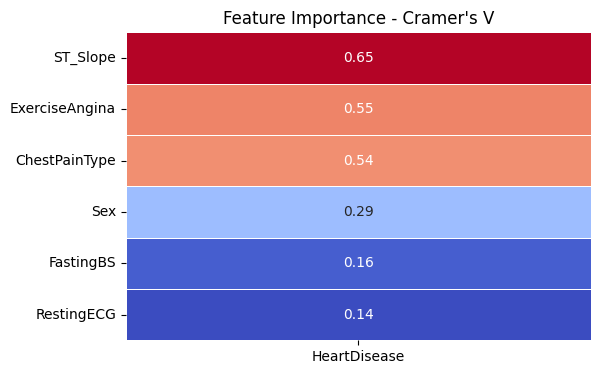

In [64]:
# Feature importance

categorical_features_V = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", 'HeartDisease']

# Create a contingency table for "HeartDisease" vs other categorical variables and calculate Cramer's V
association_matrix_V = pd.DataFrame(index=['HeartDisease'], columns=categorical_features_V[:-1])  # Excluding 'HeartDisease' for self-comparison

for feature in categorical_features_V[:-1]:  # Exclude 'HeartDisease'
    # Create a contingency table for HeartDisease vs other features
    contingency_table_V = pd.crosstab(df['HeartDisease'], df[feature])
    
    # Calculate the chi-squared statistic and p-value
    chi2, p, _, _ = chi2_contingency(contingency_table_V)
    
    # Calculate Cramer's V
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table_V.shape
    cramer_v = np.sqrt(phi2 / min((k - 1), (r - 1)))
    
    association_matrix_V.loc['HeartDisease', feature] = cramer_v

# Convert the association matrix to a numeric format (float)
association_matrix_V = association_matrix_V.astype(float)

# Sort columns by the strength of association with 'HeartDisease'
association_matrix_V = association_matrix_V.sort_values(by='HeartDisease', axis=1, ascending=False)

# Create a heatmap for HeartDisease vs other variables
plt.figure(figsize=(6, 4))
sns.heatmap(association_matrix_V.T, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5, cbar=False)
plt.title("Feature Importance - Cramer's V")
plt.show()

Insights:
- ST_Slope (0.65): The highest Cramer's V value indicates a strong association between ST_Slope and HeartDisease. A high value like 0.65 suggests that changes in ST_Slope are likely to be informative about the presence or absence of HeartDisease.
- ExerciseAngina (0.55): This variable also has strong association with HeartDisease. The presence or absence of exercise-induced angina appears to be associated with the likelihood of HeartDisease.
- ChestPainType (0.54): This variable also shows a strong association with HeartDisease. The pattern of chest pain types appears to be informative about the likelihood of HeartDisease.
- Sex (0.29): Sex has a moderate association with HeartDisease. This suggests that there might be some gender-related differences in the occurrence of HeartDisease, but it's not as strong as the associations found in the previous variables.
- FastingBS (0.16): Fasting blood sugar shows a weaker association with HeartDisease. The level of association suggests that fasting blood sugar levels may provide some information about the presence of HeartDisease.
- RestingECG (0.14): Resting electrocardiographic results have the weakest association with HeartDisease compared to the other variables. It might still contribute some information but to a lesser extent.

### 2.5.7 Summary of Comparative Statistics and Associations 

In this chapter, we analyzed the dataset features, dividing them into two parts. 

First, we examined the numerical features and drew the following conclusions:
1. From the boxplot, we observed that the most important features regarding the occurrence of heart disease were Oldpeak, MaxHR, and Age.
2. Through pairwise correlations (Pearson's r), we found no collinearity issues, as none of the variable pairs exhibited very high correlation.
3. Based on the ANOVA F statistics and their corresponding p-values, we noted that all numerical features are statistically significant at both 5% and 1% significance levels.
4. We assessed feature importance using Pearson's r for every feature against the target variable. The most correlated features, in absolute values, were Oldpeak, followed by MaxHR and Age.

In this sub-section, we prepare the data in a suitable way so that it can be fed into the models. Data preprocessing is a basic and essential step for converting raw data into useful information. Secondly, we examined the categorical features and drew the following conclusions:
1. From the count plot, we observed the following:
    - The majority of females (78%) do not have heart disease, while the majority of males (56%) do have heart disease.
    - Surprisingly, when it comes to "ChestPainType," 74.1% of patients with Asymptomatic chest pain have heart disease.
    - It's noteworthy that 65.6% of individuals with fasting blood sugar levels > 120 mg/dL have heart disease. 
    - Individuals without Normal value in Resting Electrocardiogram Results tend to have Heart Disease. 
    - It's evident that patients with angina originating from exercise have a significantly higher prevalence of heart disease (82.6%) compared to those with angina not originating from exercise, where only 25.9% have heart disease.
    - The majority of individuals with an upsloping ST slope do not have heart disease. In contrast, the majority of those with a downsloping or flat ST slope do have heart disease.
2. Through pairwise Associations (Cramer’s V), we found that none of the variable pairs exhibit a very high association. 
3. Based on the Chi Square Scores and their corresponding p-values, we noted that all categorical features are statistically significant at a 5% significance level.
4. We assessed feature importance using Cramer's V for every categorical feature against the target variable. The most associated features were ST_Slope followed by ExerciseAngina  and ChestPainType.


# 3 Modelling

## 3.1 Data Preprocessing

In this sub-section, we prepare the data in a suitable way so that it can be fed into the models. Data preprocessing is a basic and essential step for converting raw data into useful information. 

## 3.1.1 Encoding

First, we encode the categorical features. The method we use is called “One hot encoding” or “Dummy variable encoding”, which is a crucial preprocessing technique used to convert categorical data into a format that machine learning algorithms can better understand. This method is particularly useful when the categorical data does not have an inherent order or ranking.

In [65]:
# One hot encoding

# We choose the categorical features
features_to_encode = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=features_to_encode, drop_first=True) # The drop_first=True argument will drop the first category for each encoded column

# Display the new encoded DataFrame
df_encoded.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


In [66]:
# check the encoded dataframe
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                746 non-null    int64  
 1   RestingBP          746 non-null    int64  
 2   Cholesterol        746 non-null    int64  
 3   FastingBS          746 non-null    int64  
 4   MaxHR              746 non-null    int64  
 5   Oldpeak            746 non-null    float64
 6   HeartDisease       746 non-null    int64  
 7   Sex_M              746 non-null    uint8  
 8   ChestPainType_ATA  746 non-null    uint8  
 9   ChestPainType_NAP  746 non-null    uint8  
 10  ChestPainType_TA   746 non-null    uint8  
 11  RestingECG_Normal  746 non-null    uint8  
 12  RestingECG_ST      746 non-null    uint8  
 13  ExerciseAngina_Y   746 non-null    uint8  
 14  ST_Slope_Flat      746 non-null    uint8  
 15  ST_Slope_Up        746 non-null    uint8  
dtypes: float64(1), int64(6), u

As we can see from the above outputs, every categorical feature has been successfully transformed into numerical. So, “zero” indicates the absence of the feature and “one” indicates the presence.

### 3.1.2 Dataset: Train - Test Split

Data leakage occurs during data preprocessing when information from the testing set is used in training, leading to overfitting and inflated accuracy scores. This sharing of information will give the model a ‘heads-up’ about the testing dataset and generate seemingly optimal evaluation scores. However, since the model overfits the testing data, it cannot predict accurately on future unseen datasets.

One of the common causes of data leakage is due to train-test split after certain data processing steps. So, in order to avoid data leakage, we’re going to split the dataset into train and test set before scaling the data.

1. Pre-modelling Assigning

In [67]:
# Assigning independent variables to X and the dependent-target variable to y
X = df_encoded.drop(['HeartDisease'], axis=1) # all the variables except the target variable (HeartDisease)
y = df_encoded['HeartDisease']

2. Train - Test split (80:20 ratio)

In [68]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Resetting index in place for both X and y
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [69]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596 entries, 0 to 595
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                596 non-null    int64  
 1   RestingBP          596 non-null    int64  
 2   Cholesterol        596 non-null    int64  
 3   FastingBS          596 non-null    int64  
 4   MaxHR              596 non-null    int64  
 5   Oldpeak            596 non-null    float64
 6   Sex_M              596 non-null    uint8  
 7   ChestPainType_ATA  596 non-null    uint8  
 8   ChestPainType_NAP  596 non-null    uint8  
 9   ChestPainType_TA   596 non-null    uint8  
 10  RestingECG_Normal  596 non-null    uint8  
 11  RestingECG_ST      596 non-null    uint8  
 12  ExerciseAngina_Y   596 non-null    uint8  
 13  ST_Slope_Flat      596 non-null    uint8  
 14  ST_Slope_Up        596 non-null    uint8  
dtypes: float64(1), int64(5), uint8(9)
memory usage: 33.3 KB


In [70]:
X_train.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,39,160,147,1,160,0.0,1,0,1,0,1,0,0,0,1
1,65,138,282,1,174,1.4,1,0,0,1,0,0,0,1,0
2,48,124,274,0,166,0.5,1,0,0,0,0,0,0,1,0
3,44,118,242,0,149,0.3,0,0,1,0,1,0,0,1,0
4,51,137,339,0,127,1.7,1,0,1,0,1,0,1,1,0


Having successfully split the dataset into train-test sets, we proceed to the final data preprocessing step, which is scaling the data.

### 3.1.3 Scaling

Feature scaling is a method in data preprocessing that adjusts the values of features within a dataset to a comparable scale. Its aim is to ensure equal contribution from all features to the model while preventing the dominance of features with larger values.

- On one hand, distanced-based algorithms like k-Nearest Neighbors and gradient descent-based algorithms like Logistic Regression require data to be scaled.
- One the other hand, tree-based algorithms like Decision Trees and Random Forest are insensitive to scaling. 
- As for Naive Bayes classifiers such as Gaussian Naive Bayes and Bernoulli Naive Bayes, they typically don't require scaling. Naive Bayes classifiers compute probabilities based on the distribution of features and assume independence among them. Since scaling does not affect the probabilities or the independence assumption, it's generally unnecessary to scale features when using Naive Bayes classifiers.

In this sub-section we are going to scale the data with:
1) MinMaxScaler
2) StandardScaler

In [71]:
def scale_dataframe(scaler, dataframe, columns_to_scale, one_hot_encoded_columns):
    # Select the columns to scale from the original DataFrame
    dataframe_to_scale = dataframe[columns_to_scale]

    # Fit and transform the selected columns
    scaled_data = scaler.fit_transform(dataframe_to_scale)

    # Create new DataFrame with the scaled columns
    scaled_dataframe = pd.DataFrame(scaled_data, columns=columns_to_scale, index=dataframe.index)

    # Concatenate the one-hot encoded columns with the scaled columns using the index
    final_dataframe = pd.concat([dataframe[one_hot_encoded_columns], scaled_dataframe], axis=1)

    return final_dataframe

# Select columns for scaling
columns_to_scale = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Exclude one-hot-encoded columns
one_hot_encoded_columns_train = [col for col in X_train.columns if col not in columns_to_scale]
one_hot_encoded_columns_test = [col for col in X_test.columns if col not in columns_to_scale]

# For Min-Max Scaling
min_max_scaler = MinMaxScaler()
X_train_normalized = scale_dataframe(min_max_scaler, X_train, columns_to_scale, one_hot_encoded_columns_train)
X_test_normalized = scale_dataframe(min_max_scaler, X_test, columns_to_scale, one_hot_encoded_columns_test)

# For Standard Scaling
standard_scaler = StandardScaler()
X_train_standarized = scale_dataframe(standard_scaler, X_train, columns_to_scale, one_hot_encoded_columns_train)
X_test_standarized = scale_dataframe(standard_scaler, X_test, columns_to_scale, one_hot_encoded_columns_test)

In [72]:
# # Exaple without the def function (cross check)

# # Normalize the numerical continuous features
# min_max_scaler = MinMaxScaler()

# # Select the columns to scale from the original DataFrame
# columns_to_scale = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# # Select the dataframes to scale from the original DataFrame
# dataframe_to_scale_train = X_train[columns_to_scale]
# dataframe_to_scale_test = X_test[columns_to_scale]

# # Fit and transform the selected columns of Training set
# scaled_data_train = min_max_scaler.fit_transform(dataframe_to_scale_train)

# # Transform the selected columns of Test set
# scaled_data_test = min_max_scaler.transform(dataframe_to_scale_test)

# # Create new DataFrames with the scaled columns
# X_train_normalized = pd.DataFrame(scaled_data_train, columns=columns_to_scale)
# X_test_normalized= pd.DataFrame(scaled_data_test, columns=columns_to_scale)

# # Concatenate the one-hot encoded columns with the scaled columns for Training set
# one_hot_encoded_columns_train = [col for col in X_train.columns if col not in columns_to_scale]
# X_train_normalized = pd.concat([X_train[one_hot_encoded_columns_train], X_train_normalized], axis=1)

# # Concatenate the one-hot encoded columns with the scaled columns for Test set
# one_hot_encoded_columns_test = [col for col in X_test.columns if col not in columns_to_scale]
# X_test_normalized = pd.concat([X_test[one_hot_encoded_columns_test], X_test_normalized], axis=1)

In [73]:
X_train_normalized.head()

,FastingBS,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,1,1,0,1,0,1,0,0,0,1,0.224490,0.629630,0.119691,0.728,0.015873
1,1,1,0,0,1,0,0,0,1,0,0.755102,0.425926,0.380309,0.840,0.238095
2,0,1,0,0,0,0,0,0,1,0,0.408163,0.296296,0.364865,0.776,0.095238
3,0,0,0,1,0,1,0,0,1,0,0.326531,0.240741,0.303089,0.640,0.063492
4,0,1,0,1,0,1,0,1,1,0,0.469388,0.416667,0.490347,0.464,0.285714


In [74]:
X_train_standarized.head()

,FastingBS,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,1,1,0,1,0,1,0,0,0,1,-1.488742,1.559413,-1.657558,0.827799,-0.839637
1,1,1,0,0,1,0,0,0,1,0,1.263530,0.297173,0.632989,1.401244,0.466222
2,0,1,0,0,0,0,0,0,1,0,-0.536032,-0.506071,0.497253,1.073561,-0.373259
3,0,0,0,1,0,1,0,0,1,0,-0.959459,-0.850318,-0.045691,0.377234,-0.559810
4,0,1,0,1,0,1,0,1,1,0,-0.218462,0.239799,1.600110,-0.523894,0.746049


In [75]:
# Shape before scaling
print('Shape before scaling')
print(X_train.shape)
print(X_test.shape)

print('')

# Shape after Normalization
print('Shape after Normalization')
print(X_train_normalized.shape)
print(X_test_normalized.shape)

print('')

# Shape after Standarization
print('Shape after Standarization')
print(X_train_standarized.shape)
print(X_test_standarized.shape)

Shape before scaling
(596, 15)
(150, 15)

Shape after Normalization
(596, 15)
(150, 15)

Shape after Standarization
(596, 15)
(150, 15)


Now, we have three data frames ready to be fed into the algorithms:
1) Raw dataframe: Without scaling
2) Normalized dataframe: Scaled through normalization 
3) Standardized dataframe : Scaled through standardization

## 3.2 Algorithms

In situations where the consequences of missing true positive cases are significant, as seen in the case of a patient with heart disease going undetected, the emphasis should be placed on maximizing Recall rather than overall accuracy. The rationale behind this preference lies in the importance of identifying all actual instances of the condition, even if it means occasionally classifying a patient as having heart disease when they do not. 

This approach prioritizes Recall, striving to minimize false negatives and reduce the likelihood of overlooking critical health issues. By favoring Recall, the focus shifts towards comprehensive detection, ensuring a more thorough screening for potential cases of heart disease to enhance overall patient safety

### 3.2.1 K - Nearest Neighbors (KNN) - Normalized data

1. TRAINING PHASE

The most critical hyperparameter in the KNN algorithm is the number of nearest neighbors, denoted as k. Therefore, we employ Grid Search in conjunction with Cross Validation to determine the optimal value for k, which maximizes the recall score.

The often-used rule of thumb is that k equals the square root of the number of points in the training data. So, with 596 training samples, the square root of them is 24.41. This can serve as a starting point for GridSearchCV. 

In [76]:
# Apply GridSearchCV to find the optimal k

# Create KNN classifier
knn = KNeighborsClassifier()

# Create space of candidate values
search_space = {"n_neighbors": [24, 25, 26, 27, 28, 29, 30]}

# Create grid search
grid_search = GridSearchCV(
    knn, param_grid=search_space, 
    cv=5, 
    n_jobs=-1, 
    scoring=make_scorer(recall_score, greater_is_better=True))

# Fit the grid_search
grid_search.fit(X_train_normalized, y_train)

# Get the best parameters
best_params_n = grid_search.best_params_

# Store the best value of k
best_k_norm = best_params_n['n_neighbors']

# Evaluate the model on the training set
train_score = grid_search.score(X_train_normalized, y_train)

# Print the results
print("Best Parameters:", best_params_n)
print("Training Set Recall: {:.3f}".format(train_score))

Best Parameters: {'n_neighbors': 27}
Training Set Recall: 0.880


So, the optimal k is equal to 27 and the training set recall is 0.88.

Next, we construct the KNN model with k equal to 27.

In [77]:
# Building knn model with best k
knn_norm = KNeighborsClassifier(n_neighbors=best_k_norm, n_jobs=-1)

# Fit the model to the training set
knn_norm.fit(X_train_normalized, y_train)

# Predictions on training set
y_train_knn_pred = knn_norm.predict(X_train_normalized)
train_recall = recall_score(y_train, y_train_knn_pred, average='binary')

print("Train set Recall: {:.3f}".format(train_recall))

Train set Recall: 0.880


Now that we have built the model, we use a 5-fold cross validation to measure the performance in a more robust manner.

In [78]:
# Cross Validation

k_fold = 5

# Use recall as the scoring metric
scorer = make_scorer(recall_score, average='binary')

# Perform cross-validation and obtain recall scores for each fold
scores = cross_val_score(knn_norm, X_train_normalized, y_train, cv=k_fold, scoring=scorer)

# Print the recall for each fold
for fold, score in enumerate(scores):
    print(f"Fold {fold+1} recall: {score:.3f}")

# Calculate and print the average recall across all folds
average_recall = scores.mean()
print(f"Average recall: {average_recall:.3f}")

Fold 1 recall: 0.912
Fold 2 recall: 0.929
Fold 3 recall: 0.877
Fold 4 recall: 0.860
Fold 5 recall: 0.877
Average recall: 0.891


The recall scores across the folds do not vary significantly, indicating a stable performance of the model across different subsets of the data. The average recall score of 0.891 reflects the overall performance of the model across all folds. This indicates that, on average, the model successfully recalls approximately 89.1% of the positive instances in the dataset.

Finally, we visualize the performance of the trained KNN model through a confusion matrix. 

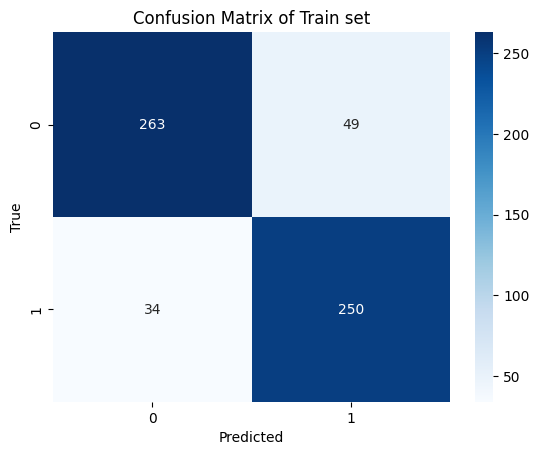

In [79]:
# Confusion matrix - Train set
cm_knn_train = confusion_matrix(y_train, y_train_knn_pred)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm_knn_train, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix of Train set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

From the confusion matrix we see that:
- 250 heart disease cases were correctly predicted out of 284 total. That gives a Recall of 0.880.
- 250 heart disease cases were correctly predicted out of 299 predicted cases as heart disease. That gives a Precision of 0.836.
- 513 instances were correctly predicted out of 596 total. That gives an Accuracy of 0.861.

These results are particularly encouraging, notably the high Recall, indicating our ability to capture a significant number of heart diseases accurately. So, the KNN algorithm is trained and ready to be tested and evaluated in our separate test set.

2. TESTING PHASE

First, we make predictions on the test set and print the Recall.

In [80]:
# Predictions on test set
y_test_knn_pred = knn_norm.predict(X_test_normalized)
test_recall = recall_score(y_test, y_test_knn_pred, average='binary')

print("Test set Recall: {:.3f}".format(test_recall))

Test set Recall: 0.917


We have a very satisfying Recall of 0.917 on the test set.

Next, we construct the confusion matrix

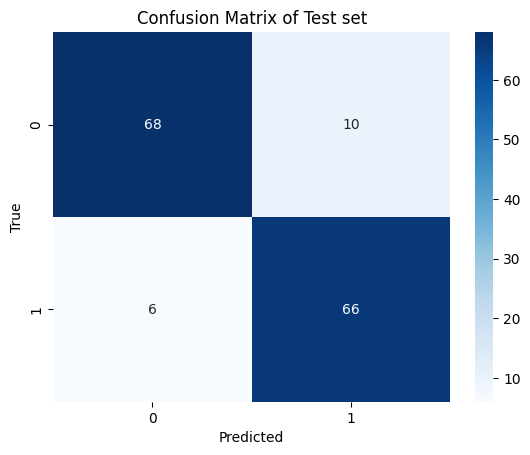

In [81]:
# Confusion matrix - Test set
cm_knn_test = confusion_matrix(y_test, y_test_knn_pred)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm_knn_test, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix of Test set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

As we see from the confusion matrix, the results are quite good. Now we present the Classification Report to see all the evaluation metrics in depth. 

In [82]:
# Classification Report for KNN with k=27
print(classification_report(y_test, y_test_knn_pred))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89        78
           1       0.87      0.92      0.89        72

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150



This classification report summarizes the performance of the KNN model. Here's a breakdown of the key metrics:
- Precision:
    - For class 0 (no Heart Disease), precision is 0.92, which means that among the instances predicted as class 0, 92% of them are actually class 0.
    - For class 1 (Heart Disease), precision is 0.87, indicating that among the instances predicted as class 1, 87% of them are actually class 1.
- Recall:
    - For class 0, recall is 0.87, meaning that the model correctly identifies 87% of the instances belonging to class 0.
    - For class 1, recall is 0.92, indicating that the model correctly identifies 92% of the instances belonging to class 1.
- F1-score: For both classes 0 and 1, the F1-score is 0.89, suggesting a balanced performance in terms of precision and recall.
- Support: Is the number of actual occurrences of the class in the specified dataset.
    - For class 0, there are 78 instances, and for class 1, there are 72 instances in the test set.
- Accuracy: The overall accuracy of the model is 0.89, which means that 89% of the instances in the test set were correctly classified.
- Macro Avg: The macro average is the unweighted mean of precision, recall, and F1-score across all classes. In this case, it is 0.89.
- Weighted Avg: The weighted average considers the number of occurrences of each class during computation. It is the weighted mean of precision, recall, and F1-score across all classes. In this case, it is also 0.89.


Finally, we present the ROC curve

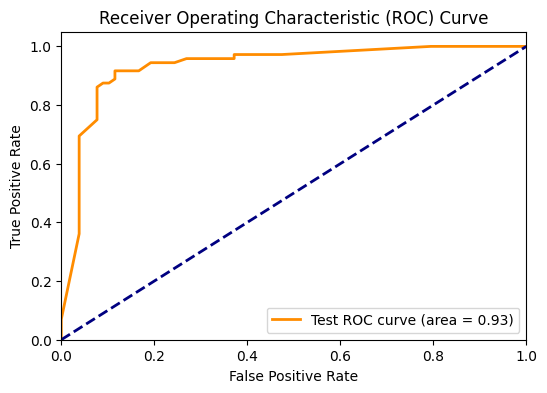

In [83]:
# ROC-AUC

# Get predicted probabilities
y_test_probs = knn_norm.predict_proba(X_test_normalized)[:, 1]

# Compute True and False Positive Rates
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)

# Compute Area Under the Curve (AUC)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='Test ROC curve (area = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

From this graph, we see that AUC is 0.93, which means there is a 93% chance that the model will be able to distinguish between positive class and negative class.

Overall, the KNN model with k=27 appears to perform quite well, achieving high precision, recall, and F1-scores for both classes, as well as a respectable overall accuracy of 89%. It seems to have balanced performance across the different metrics, indicating a reliable classification model. It also has good separability as it yields an AUC score of 0.93. Finally, for the task at hand, the most important metric is Recall (True Positive Rate) which is equal to an exceptional 0.92. Thus, the model can potentially capture 92 out of 100 heart disease cases.

### 3.2.2 K - Nearest Neighbors (KNN) - Standarized data

The same procedure is also applied in standarized data, but the results are slightly weaker. So we write the script codes without commentation

1. TRAINING PHASE

In [84]:
# Apply GridSearchCV to find the optimal k

# Fit the grid_search
grid_search.fit(X_train_standarized, y_train)

# Get the best parameters
best_params_s = grid_search.best_params_

# Store the best value of k
best_k_stand = best_params_s['n_neighbors']

# Evaluate the model on the training set
train_score = grid_search.score(X_train_standarized, y_train)

# Print the results
print("Best Parameters:", best_params_s)
print("Training Set Recall: {:.3f}".format(train_score))

Best Parameters: {'n_neighbors': 25}
Training Set Recall: 0.849


In [85]:
# Building knn model with best_k
knn_stand = KNeighborsClassifier(n_neighbors=best_k_stand, n_jobs=-1)

# Fit the model to the dataset
knn_stand.fit(X_train_standarized, y_train)

# Predictions on training set
y_train_knn_pred_standarized = knn_stand.predict(X_train_standarized)
train_recall = recall_score(y_train, y_train_knn_pred_standarized, average='binary')

print("Train set Recall: {:.3f}".format(train_recall))

Train set Recall: 0.849


In [86]:
# Cross Validation

k_fold = 5

# Use recall as the scoring metric
scorer = make_scorer(recall_score, average='binary')

# Perform cross-validation and obtain recall scores for each fold
scores = cross_val_score(knn_stand, X_train_standarized, y_train, cv=k_fold, scoring=scorer)

# Print the recall for each fold
for fold, score in enumerate(scores):
    print(f"Fold {fold+1} recall: {score:.3f}")

# Calculate and print the average recall across all folds
average_recall = scores.mean()
print(f"Average recall: {average_recall:.3f}")

Fold 1 recall: 0.877
Fold 2 recall: 0.911
Fold 3 recall: 0.807
Fold 4 recall: 0.789
Fold 5 recall: 0.772
Average recall: 0.831


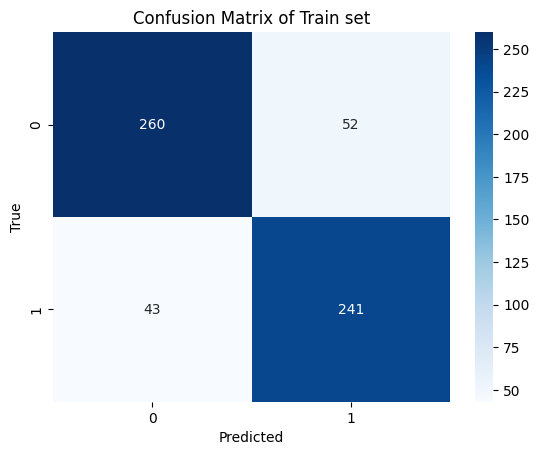

In [87]:
# Confusion matrix- Train set
cm_knn_train_standarized = confusion_matrix(y_train, y_train_knn_pred_standarized)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm_knn_train_standarized, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix of Train set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

2. TESTING PHASE

In [88]:
# Predictions on test set
y_test_knn_pred_standarized = knn_stand.predict(X_test_standarized)
test_recall = recall_score(y_test, y_test_knn_pred_standarized, average='binary')

print("Test set Recall: {:.3f}".format(test_recall))

Test set Recall: 0.875


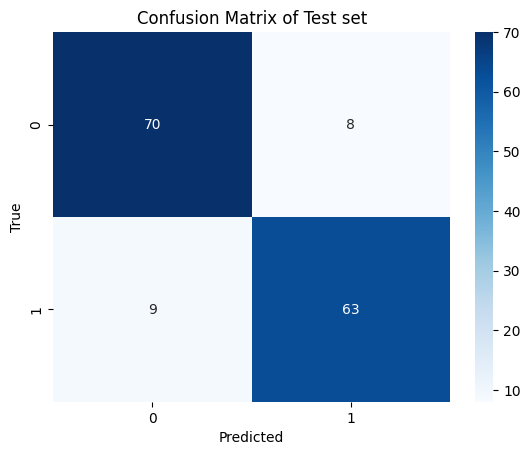

In [89]:
# Confusion matrix - Test set
cm_knn_test_standarized = confusion_matrix(y_test, y_test_knn_pred_standarized)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm_knn_test_standarized, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix of Test set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [90]:
# Classification Report for KNN with k=25
print(classification_report(y_test, y_test_knn_pred_standarized))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89        78
           1       0.89      0.88      0.88        72

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150



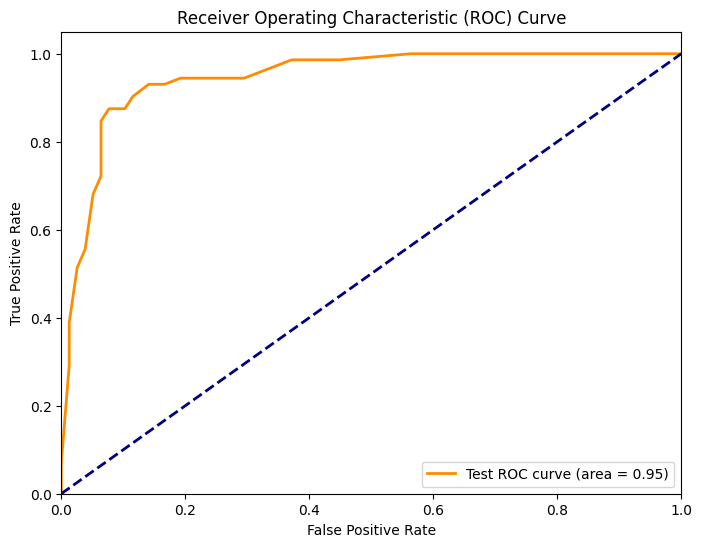

In [91]:
# ROC-AUC

# Get predicted probabilities
y_test_probs_standarized = knn_stand.predict_proba(X_test_standarized)[:, 1]

# Compute True and False Positive Rates
fpr_test_s, tpr_test_s, _ = roc_curve(y_test, y_test_probs_standarized)

# Compute Area Under the Curve (AUC)
roc_auc_test_s = auc(fpr_test_s, tpr_test_s)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_test_s, tpr_test_s, color='darkorange', lw=2, label='Test ROC curve (area = {:.2f})'.format(roc_auc_test_s))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### 3.2.3 Logistic Regression - Normalized data

1) TRAINING PHASE

Regularization is a technique used in machine learning and statistical modeling to prevent overfitting and improve the generalization ability of a model. It does this by adding a penalty term to the objective function (usually called the loss function) that the model is trying to minimize. By adding a penalty term to the objective function, regularization helps to reduce the complexity of the model and prevent it from overfitting. 

The most critical hyperparameters in the Logistic Regression algorithm are “C”  and “penalty” . Therefore, we employ Grid Search in conjunction with Cross Validation to determine the optimal values for “C” and “penalty”, which maximize the recall score.

In [92]:
# Apply GridSearchCV to find the optimal c and penalty

# Create Logistic Regression classifier
logistic_reg = LogisticRegression(random_state=0)

# Create space of candidate values for C and penalty
search_space = {
            "C": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
            "penalty": ['l2', None]
               }

# Create grid search
grid_search = GridSearchCV(
    logistic_reg, 
    param_grid=search_space, 
    cv=5, n_jobs=-1, 
    scoring=make_scorer(recall_score, greater_is_better=True))

# Fit the grid_search
grid_search.fit(X_train_normalized, y_train)

# Get the best parameters
best_params_n = grid_search.best_params_

# Store the best value of c and penalty
best_c_norm = best_params_n['C']
best_penalty_norm = best_params_n['penalty']

# Evaluate the model on the training set
train_score = grid_search.score(X_train_normalized, y_train)

# Print the results
print("Best Parameters:", best_params_n)
print("Training Set Recall: {:.3f}".format(train_score))

Best Parameters: {'C': 0.2, 'penalty': 'l2'}
Training Set Recall: 0.877


So, the optimal “C” is equal to 0.2, and the optimal “penalty” is l2. These hyperparameters values yield a training set recall of  0.877.

Next, we construct the Logistic Regression model using these optimal values.

In [93]:
# Building logistic regression model with best_c and penalty
logreg_norm = LogisticRegression(random_state=0, **best_params_n)

# Fit the model to the dataset
logreg_norm.fit(X_train_normalized, y_train)

# Predictions on training set
y_train_logreg_norm_pred = logreg_norm.predict(X_train_normalized)
train_recall = recall_score(y_train, y_train_logreg_norm_pred, average='binary')

print("Train set Recall: {:.3f}".format(train_recall))

Train set Recall: 0.877


Now that we have built the model, we use a 5-fold cross validation to measure the performance in a more robust manner. 

In [94]:
# Cross Validation

k_fold = 5

# Use recall as the scoring metric
scorer = make_scorer(recall_score, average='binary')

# Perform cross-validation and obtain recall scores for each fold
scores = cross_val_score(logreg_norm, X_train_normalized, y_train, cv=k_fold, scoring=scorer)

# Print the recall for each fold
for fold, score in enumerate(scores):
    print(f"Fold {fold+1} recall: {score:.3f}")

# Calculate and print the average recall across all folds
average_recall = scores.mean()
print(f"Average recall: {average_recall:.3f}")

Fold 1 recall: 0.912
Fold 2 recall: 0.911
Fold 3 recall: 0.842
Fold 4 recall: 0.789
Fold 5 recall: 0.877
Average recall: 0.866


The recall scores across the folds display modest variances, indicating a somewhat stable performance of the model across different subsets of the data. The average recall score of 0.866 reflects the overall performance of the model across all folds, suggesting that, on average, the model successfully recalls approximately 86.6% of the positive instances in the dataset.

Finally, we visualize the performance of the trained Logistic Regression model through a confusion matrix. 

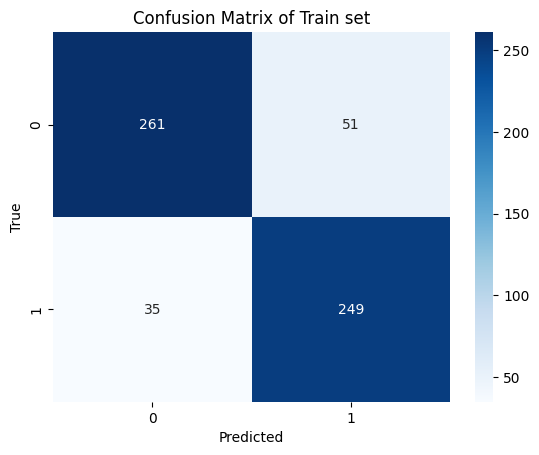

In [95]:
# Confusion matrix - Train set
cm_logreg_norm_train = confusion_matrix(y_train, y_train_logreg_norm_pred)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm_logreg_norm_train, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix of Train set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

From the confusion matrix, we see that:
- 249 heart disease cases were correctly predicted out of 284 total. That gives a Recall of 0.877.
- 249 heart disease cases correctly predicted out of 300 predicted cases as heart disease. That gives a Precision of 0.830.
- 510 instances were correctly predicted out of 596 total. That gives an Accuracy of 0.856.

These results are particularly encouraging, notably the high Recall, indicating our ability to capture a significant number of heart diseases accurately.
So, the Logistic Regression algorithm is trained and ready to be tested and evaluated in our separate test set. 

But, before we continue with testing the algorithm, we present the coefficients of the Logistic Regression model:

In [96]:
coefficients = pd.DataFrame(logreg_norm.coef_.flatten(), index=X_train_normalized.columns, columns=['Coefficient'])
print(coefficients)

                   Coefficient
FastingBS             0.220821
Sex_M                 1.112711
ChestPainType_ATA    -1.038527
ChestPainType_NAP    -1.027811
ChestPainType_TA     -0.601127
RestingECG_Normal    -0.225875
RestingECG_ST         0.006738
ExerciseAngina_Y      0.998488
ST_Slope_Flat         0.982000
ST_Slope_Up          -1.136329
Age                   0.576155
RestingBP             0.306380
Cholesterol           0.219561
MaxHR                -0.328971
Oldpeak               0.706013


From the above output, we can see that the features (in absolute values) that seem to contribute the least are:
- RestingECG_ST = 0.006738
- Cholesterol = 0.219561
- FastingBS = 0.220821
- RestingECG_Normal = 0.225875

These findings are consistent with the previous analysis of feature importances (Point Biserial Correlation and Cramer’s V).

2. TESTING PHASE

First, we make predictions on the test set and print the Recall. 

In [97]:
# Predictions on test set
y_test_logreg_norm_pred = logreg_norm.predict(X_test_normalized)
test_recall = recall_score(y_test, y_test_logreg_norm_pred, average='binary')

print("Test set Recall: {:.3f}".format(test_recall))

Test set Recall: 0.889


We have a satisfying Recall of 0.889 on the test set.

Next, we construct the confusion matrix.

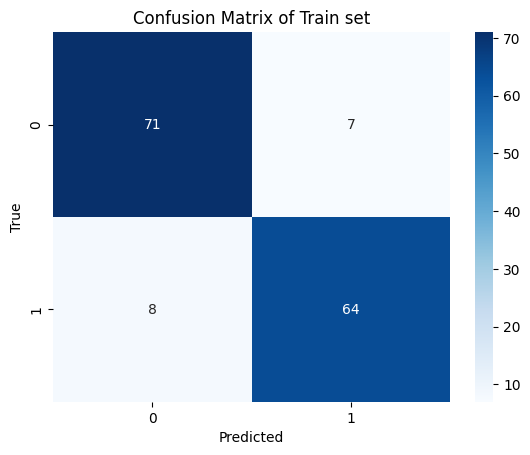

In [98]:
# Confusion matrix - Test set
cm_logreg_norm_test = confusion_matrix(y_test, y_test_logreg_norm_pred)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm_logreg_norm_test, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix of Train set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

As we see from the confusion matrix, the results are quite good. Now we present Classification Report to see all the evaluation metrics in depth. 

In [99]:
# Classification Report for Logistic Regression with c = 0.2 and penalty = l2
print(classification_report(y_test, y_test_logreg_norm_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90        78
           1       0.90      0.89      0.90        72

    accuracy                           0.90       150
   macro avg       0.90      0.90      0.90       150
weighted avg       0.90      0.90      0.90       150



This classification report summarizes the performance of the of the Logistic Regression model. Here's a breakdown of the key metrics:
- Precision:
    - For class 0 (no Heart Disease), precision is 0.90, which means that among the instances predicted as class 0, 90% of them are actually class 0.
    - For class 1 (Heart Disease), precision is 0.90, indicating that among the instances predicted as class 1, 90% of them are actually class 1.
- Recall:
    - For class 0, recall is 0.91, meaning that the model correctly identifies 91% of the instances belonging to class 0.
    - For class 1, recall is 0.89, indicating that the model correctly identifies 89% of the instances belonging to class 1.
- F1-score: For both classes 0 and 1, the F1-score is 0.90, suggesting a balanced performance in terms of precision and recall.
- Support: Support is the number of actual occurrences of the class in the specified dataset.
    - For class 0, there are 78 instances, and for class 1, there are 72 instances in the test set.
- Accuracy: The overall accuracy of the model is 0.90, which means that 90% of the instances in the test set were correctly classified.
- Macro Avg: The macro average is the unweighted mean of precision, recall, and F1-score across all classes. In this case, it is 0.90.
- Weighted Avg: The weighted average considers the number of occurrences of each class during computation. It is the weighted mean of precision, recall, and F1-score across all classes. In this case, it is also 0.90.


Finally, we present the ROC curve

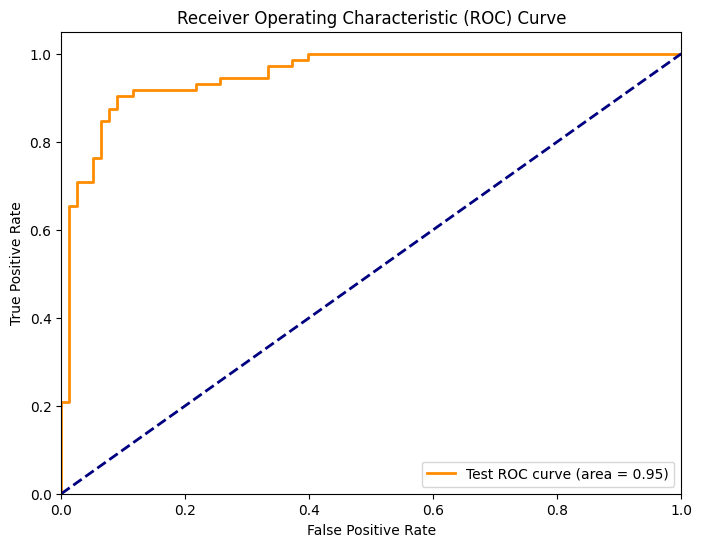

In [100]:
# ROC-AUC

# Get predicted probabilities
y_test_probs_normalized = logreg_norm.predict_proba(X_test_normalized)[:, 1]

# Compute True and False Positive Rates
fpr_test_n, tpr_test_n, _ = roc_curve(y_test, y_test_probs_normalized)

# Compute Area Under the Curve (AUC)
roc_auc_test_n = auc(fpr_test_n, tpr_test_n)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_test_n, tpr_test_n, color='darkorange', lw=2, label='Test ROC curve (area = {:.2f})'.format(roc_auc_test_n))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

From this graph, we see that AUC is 0.95, which means there is a 95% chance that the model will be able to distinguish between positive class and negative class.

Overall, the Logistic Regression model with C = 0.2 and penalty = l2 appears to perform quite well, achieving high precision, recall, and F1-scores for both classes, as well as a respectable overall accuracy of 90%. It seems to have balanced performance across the different metrics, indicating a reliable classification model. It also has an excellent separability as it yields an AUC score of 0.95. Finally, for the task at hand, the most important metric is Recall (True Positive Rate) which is equal to 0.89. Thus, the model can potentially capture 89 out of 100 heart disease cases.

### 3.2.4 Logistic Regression - Standarized data

The same procedure is also applied in standarized data, but the results are slightly weaker. So we write the script codes without commentation

1. TRAINING PHASE

In [101]:
# Apply GridSearchCV to find the optimal C

# Fit the grid_search
grid_search.fit(X_train_standarized, y_train)

# Get the best parameters
best_params_s = grid_search.best_params_

# Store the best value of C and penalty
best_c_stand = best_params_s['C']
best_penalty_s = best_params_s['penalty']

# Evaluate the model on the training set
train_score = grid_search.score(X_train_standarized, y_train)

# Print the results
print("Best Parameters:", best_params_s)
print("Training Set Recall: {:.3f}".format(train_score))

Best Parameters: {'C': 0.3, 'penalty': 'l2'}
Training Set Recall: 0.873


In [102]:
# Building logistic regression model with best_c
logreg_stand = LogisticRegression(random_state=0, **best_params_s)

# Fit the model to the dataset
logreg_stand.fit(X_train_standarized, y_train)

# Predictions on training set
y_train_logreg_stand_pred = logreg_stand.predict(X_train_standarized)
train_recall = recall_score(y_train, y_train_logreg_stand_pred, average='binary')

print("Train set Recall: {:.3f}".format(train_recall))

Train set Recall: 0.873


In [103]:
# Cross Validation

k_fold = 5

# Use recall as the scoring metric
scorer = make_scorer(recall_score, average='binary')

# Perform cross-validation and obtain recall scores for each fold
scores = cross_val_score(logreg_stand, X_train_standarized, y_train, cv=k_fold, scoring=scorer)

# Print the recall for each fold
for fold, score in enumerate(scores):
    print(f"Fold {fold+1} recall: {score:.3f}")

# Calculate and print the average recall across all folds
average_recall = scores.mean()
print(f"Average recall: {average_recall:.3f}")

Fold 1 recall: 0.912
Fold 2 recall: 0.929
Fold 3 recall: 0.842
Fold 4 recall: 0.807
Fold 5 recall: 0.807
Average recall: 0.859


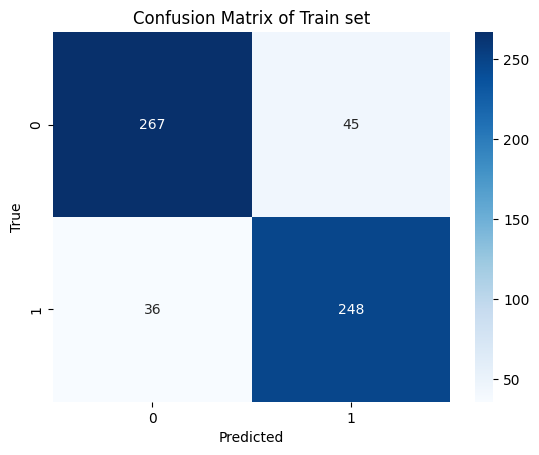

In [104]:
# Confusion matrix - Train set
cm_logreg_stand_train = confusion_matrix(y_train, y_train_logreg_stand_pred)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm_logreg_stand_train, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix of Train set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

2. TESTING PHASE

In [105]:
# Predictions on test set
y_test_logreg_stand_pred = logreg_stand.predict(X_test_standarized)
test_recall = recall_score(y_test, y_test_logreg_stand_pred, average='binary')

print("Test set Recall: {:.3f}".format(test_recall))

Test set Recall: 0.889


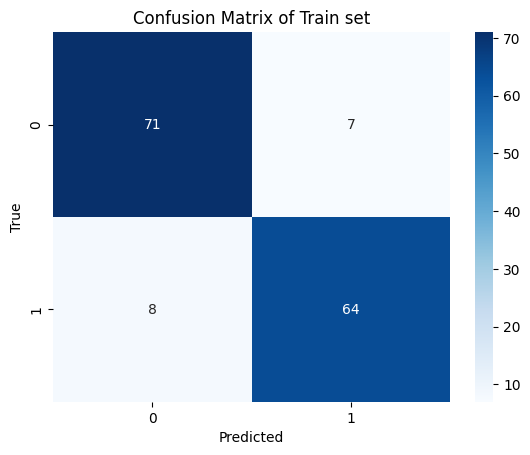

In [106]:
# Confusion matrix - Test set
cm_logreg_stand_test = confusion_matrix(y_test, y_test_logreg_stand_pred)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm_logreg_stand_test, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix of Train set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [107]:
# Classification Report for Logistic Regression with c = 0.3
print(classification_report(y_test, y_test_logreg_stand_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90        78
           1       0.90      0.89      0.90        72

    accuracy                           0.90       150
   macro avg       0.90      0.90      0.90       150
weighted avg       0.90      0.90      0.90       150



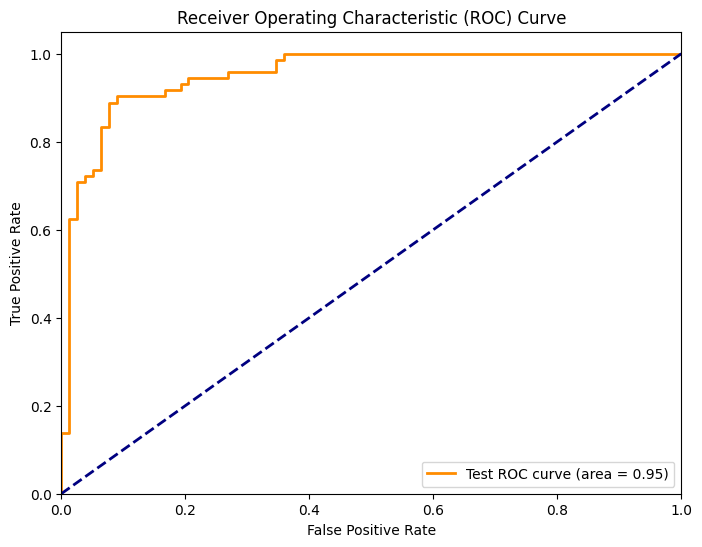

In [108]:
# ROC-AUC

# Get predicted probabilities
y_test_probs_standarized = logreg_stand.predict_proba(X_test_standarized)[:, 1]

# Compute True and False Positive Rates
fpr_test_s, tpr_test_s, _ = roc_curve(y_test, y_test_probs_standarized)

# Compute Area Under the Curve (AUC)
roc_auc_test_s = auc(fpr_test_s, tpr_test_s)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_test_s, tpr_test_s, color='darkorange', lw=2, label='Test ROC curve (area = {:.2f})'.format(roc_auc_test_s))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### 3.2.5 Logistic Regression - Normalized data - Threshold modified

1. ADJUSTING PHASE

The default decision rule for logistic regression, and many other classifiers, is to classify instances with predicted probabilities greater than or equal to 0.5 as belonging to the positive class, and those with predicted probabilities less than 0.5 as belonging to the negative class.

In our case, we prioritize capturing more positive instances (Heart Disease cases). So, we modified the threshold to 0.4. This means that any predicted probability greater than or equal to 0.4 is considered as the positive class (Heart Disease), and any probability below 0.4 is considered as the negative class (No Heart Disease).

In section 3.2.3 we have trained the Logistic Regression model. Now, we can adjust the threshold to increase Recall.

In [109]:
# Adjust the threshold
threshold = 0.4

# Get the predicted probabilities for the positive class
y_train_probs_normalized = logreg_norm.predict_proba(X_train_normalized)[:, 1]

# Modify the predictions based on the adjusted threshold
y_train_probs_modified = (y_train_probs_normalized >= threshold).astype(int)

Next, we present a Confusion Matrix to visualize the results of the Logistic Regression model with threshold equal to 0.4.

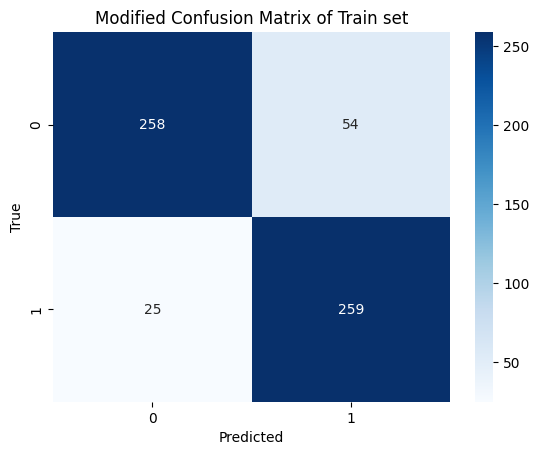

In [110]:
# Confusion matrix - Train set
cm_logreg_norm_train_modified = confusion_matrix(y_train, y_train_probs_modified)
# Plot
sns.heatmap(cm_logreg_norm_train_modified, annot=True, cmap='Blues', fmt='d')
plt.title('Modified Confusion Matrix of Train set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

From the confusion matrix we see that:
- 259 heart disease cases were correctly predicted out of 284 total. That gives a Recall of 0.912.
- 259 heart disease cases were correctly predicted  out of 313 predicted cases as heart disease. That gives a Precision of 0.828.
- 517 instances were correctly predicted  out of 596 total. That gives an Accuracy of 0.867.

These results are particularly encouraging, notably the high Recall, indicating our ability to capture a significant number of heart diseases accurately.

So, the Logistic Regression algorithm with  the modified threshold can now be tested and evaluated on a separate test set.

2. TESTING PREDICTIONS WITH THE NEW THRESHOLD

First, we make predictions on the test set.

In [111]:
# Get the predicted probabilities for the positive class
y_test_probs_normalized = logreg_norm.predict_proba(X_test_normalized)[:, 1]

# Modify the predictions based on the adjusted threshold
y_test_probs_modified = (y_test_probs_normalized >= threshold).astype(int)

Next, we present a Confusion Matrix to visualize the results. 

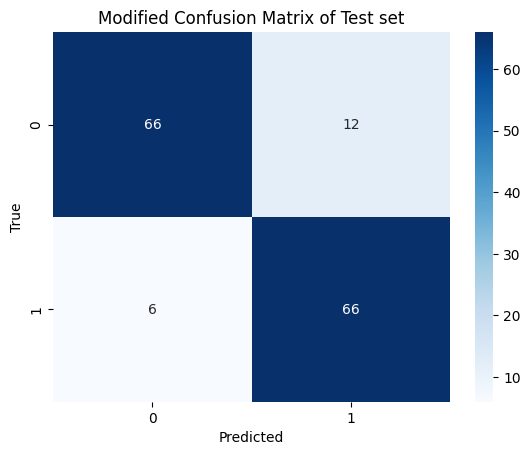

In [112]:
# Confusion matrix - Test set
cm_logreg_norm_test_modified = confusion_matrix(y_test, y_test_probs_modified)
# Plot
sns.heatmap(cm_logreg_norm_test_modified, annot=True, cmap='Blues', fmt='d')
plt.title('Modified Confusion Matrix of Test set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

As we see from the confusion matrix, the results are quite good. Now we present Classification Report to see all the evaluation metrics in depth. 

In [113]:
# Classification Report for Logistic Regression with modified threshold
print(classification_report(y_test, y_test_probs_modified))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88        78
           1       0.85      0.92      0.88        72

    accuracy                           0.88       150
   macro avg       0.88      0.88      0.88       150
weighted avg       0.88      0.88      0.88       150



This classification report summarizes the performance of the of the Logistic Regression model with the modified threshold of 0.4. Here's a breakdown of the key metrics:
- Precision:
    - For class 0 (no Heart Disease), precision is 0.92, which means that among the instances predicted as class 0, 92% of them are actually class 0.
    - For class 1 (Heart Disease), precision is 0.85, indicating that among the instances predicted as class 1, 85% of them are actually class 1.
- Recall:
    - For class 0, recall is 0.85, meaning that the model correctly identifies 85% of the instances belonging to class 0.
    - For class 1, recall is 0.92, indicating that the model correctly identifies 92% of the instances belonging to class 1.
- F1-score: For both classes 0 and 1, the F1-score is 0.88, suggesting a balanced performance in terms of precision and recall.
- Support: Support is the number of actual occurrences of the class in the specified dataset.
    - For class 0, there are 78 instances, and for class 1, there are 72 instances in the test set.
- Accuracy: The overall accuracy of the model is 0.88, which means that 88% of the instances in the test set were correctly classified.
- Macro Avg: The macro average is the unweighted mean of precision, recall, and F1-score across all classes. In this case, it is 0.88.
- Weighted Avg: The weighted average considers the number of occurrences of each class during computation. It is the weighted mean of precision, recall, and F1-score across all classes. In this case, it is also 0.88.


Finally, we present the ROC curve.

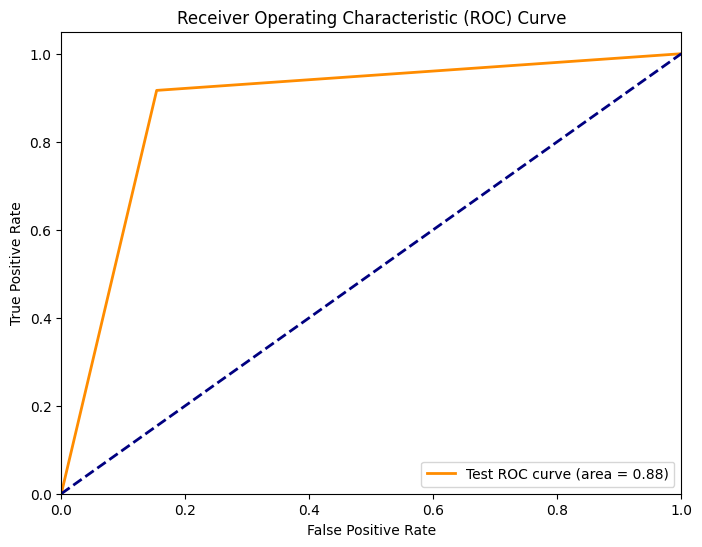

In [114]:
# ROC-AUC

# Compute True and False Positive Rates
fpr_test_n, tpr_test_n, _ = roc_curve(y_test, y_test_probs_modified)

# Compute Area Under the Curve (AUC)
roc_auc_test_n = auc(fpr_test_n, tpr_test_n)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_test_n, tpr_test_n, color='darkorange', lw=2, label='Test ROC curve (area = {:.2f})'.format(roc_auc_test_n))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

From this graph, we see that AUC is 0.88, which means there is a 88% chance that the model will be able to distinguish between positive class and negative class.

Overall, the Logistic Regression model with the modified threshold equal to 0.40, appears to perform quite well, achieving high precision, recall, and F1-scores for both classes, as well as a respectable overall accuracy of 88%. It seems to have balanced performance across the different metrics, indicating a reliable classification model. It also has a decent separability as it yields an AUC score of 0.88. Finally, for the task at hand, the most important metric is Recall (True Positive Rate) which is equal to 0.92. Thus, the model can potentially capture 92 out of 100 heart disease cases.

### 3.2.6 Naive Bayes Classifier Gausian - Raw data

1. TRAINING PHASE

First, we build on the training set.

In [115]:
# Building NBC gaussian
NBCgaussian = GaussianNB()

# Fit the model to the dataset
NBCgaussian.fit(X_train, y_train)

# Predictions on training set
y_train_NBCgaussian_pred = NBCgaussian.predict(X_train)
train_recall = recall_score(y_train, y_train_NBCgaussian_pred, average='binary')

print("Train set Recall: {:.3f}".format(train_recall))

Train set Recall: 0.849


Then, we use a 5-fold cross validation to measure the performance in a more robust manner.

In [116]:
# Cross Validation

k_fold = 5

# Use recall as the scoring metric
scorer = make_scorer(recall_score, average='binary')

# Perform cross-validation and obtain recall scores for each fold
scores = cross_val_score(NBCgaussian, X_train, y_train, cv=k_fold, scoring=scorer)

# Print the recall for each fold
for fold, score in enumerate(scores):
    print(f"Fold {fold+1} recall: {score:.3f}")

# Calculate and print the average recall across all folds
average_recall = scores.mean()
print(f"Average recall: {average_recall:.3f}")

Fold 1 recall: 0.895
Fold 2 recall: 0.893
Fold 3 recall: 0.807
Fold 4 recall: 0.825
Fold 5 recall: 0.754
Average recall: 0.835


The cross-validation results show varying recall scores across different folds. The recall values range from 0.754 to 0.895 across the five folds, indicating fluctuations in the model's ability to correctly identify positive instances. The average recall score of 0.835 suggests that the classifier performs reasonably well in terms of sensitivity to identifying true positive instances across the dataset. However, the variability in recall scores across folds indicates potential areas for improvement or further investigation.

Next, we present a Confusion Matrix to visualize the results.

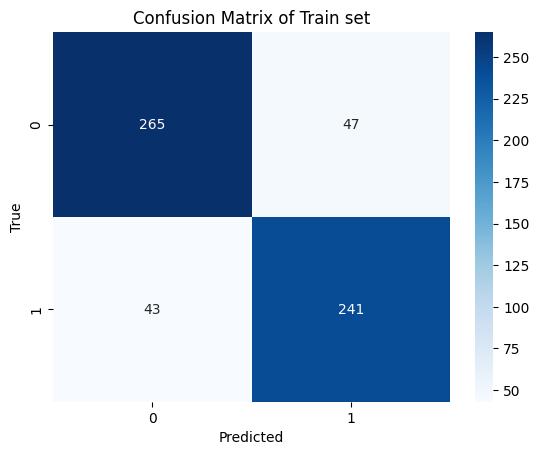

In [117]:
# Confusion matrix- Train set
cm_NBC_train = confusion_matrix(y_train, y_train_NBCgaussian_pred)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm_NBC_train, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix of Train set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

From the confusion matrix we see that:
- 241 heart disease cases were correctly predicted out of 284 total. That gives a Recall of 0.849.
- 241 heart disease cases were correctly predicted out of 288 predicted cases as heart disease. That gives a Precision of 0.837.
- 506 instances were correctly predicted out of 596 total. That gives an Accuracy of 0.849.

These results are satisfactory, though not outstanding. Gaussian Naïve Bayes Classifier can now be tested and evaluated on a separate test set.

2. TESTING PHASE

First, we make predictions on the test set and print the Recall. 

In [118]:
# Predictions on test set
y_test_NBCgaussian_pred = NBCgaussian.predict(X_test)
test_recall = recall_score(y_test, y_test_NBCgaussian_pred, average='binary')

print("Test set Recall: {:.3f}".format(test_recall))

Test set Recall: 0.917


We have a very satisfying Recall of 0.917 on the test set.

Next, we present a Confusion Matrix to visualize the results on the test set.

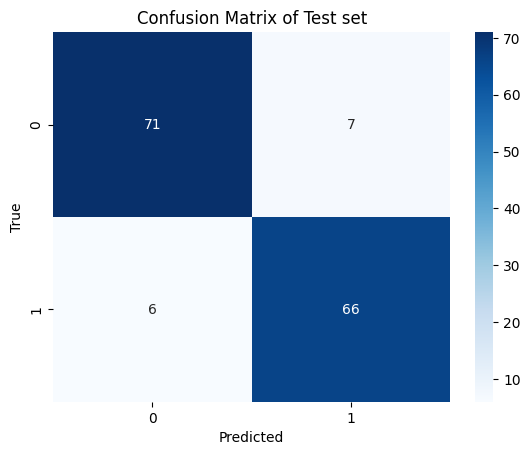

In [119]:
# Confusion matrix - Test set
cm_NBC_test = confusion_matrix(y_test, y_test_NBCgaussian_pred)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm_NBC_test, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix of Test set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

As we see from the confusion matrix, the results are impressive.

Now we present Classification Report to see all the evaluation metrics in depth.

In [120]:
# Classification Report for NBC Gaussian
print(classification_report(y_test, y_test_NBCgaussian_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92        78
           1       0.90      0.92      0.91        72

    accuracy                           0.91       150
   macro avg       0.91      0.91      0.91       150
weighted avg       0.91      0.91      0.91       150



This classification report summarizes the performance of the of the Gaussian Naïve Bayes Classifier model. Here's a breakdown of the key metrics:
- Precision:
    - For class 0 (no Heart Disease), precision is 0.92, which means that among the instances predicted as class 0, 92% of them are actually class 0.
    - For class 1 (Heart Disease), precision is 0.90, indicating that among the instances predicted as class 1, 90% of them are actually class 1.
- Recall:
    - For class 0, recall is 0.91, meaning that the model correctly identifies 91% of the instances belonging to class 0.
    - For class 1, recall is 0.92, indicating that the model correctly identifies 92% of the instances belonging to class 1.
- F1-score: 
    - For class 0, F1-score is 0.92, suggesting a balanced performance in terms of precision and recall.
    - For class 1, F1-score is 0.91, suggesting a balanced performance in terms of precision and recall.
- Support: Support is the number of actual occurrences of the class in the specified dataset.
    - For class 0, there are 78 instances, and for class 1, there are 72 instances in the test set.
- Accuracy: The overall accuracy of the model is 0.91, which means that 91% of the instances in the test set were correctly classified.
- Macro Avg: The macro average is the unweighted mean of precision, recall, and F1-score across all classes. In this case, it is 0.91.
- Weighted Avg: The weighted average considers the number of occurrences of each class during computation. It is the weighted mean of precision, recall, and F1-score across all classes. In this case, it is also 0.91.


Finally, we present the ROC curve.

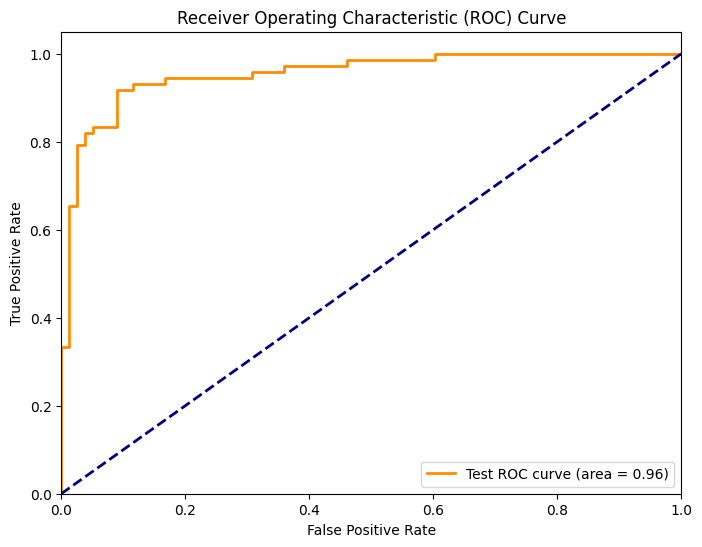

In [121]:
# ROC-AUC

# Get predicted probabilities
y_test_probs_NBCgaussian = NBCgaussian.predict_proba(X_test)[:, 1]

# Compute True and False Positive Rates
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs_NBCgaussian)

# Compute Area Under the Curve (AUC)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='Test ROC curve (area = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

From this graph, we see that AUC is 0.96, which means there is a 96% chance that the model will be able to distinguish between positive class and negative class.

Overall, the Gaussian Naïve Bayes Classifier model appears to perform quite well, achieving high precision, recall, and F1-scores for both classes, as well as a respectable overall accuracy of 91%. It seems to have balanced performance across the different metrics, indicating a reliable classification model. It also has an excellent separability as it yields an AUC score of 0.96. Finally, for the task at hand, the most important metric is Recall (True Positive Rate) which is equal to 0.92. Thus, the model can potentially capture 92 out of 100 heart disease cases.

### 3.2.7 Naive Bayes Classifier Bernoulli - Raw data

1. TRAINING PHASE

First, we build on the training set.

In [122]:
# Building NBC gaussian
NBCbernoulli = BernoulliNB()

# Fit the model to the dataset
NBCbernoulli.fit(X_train, y_train)

# Predictions on training set
y_train_NBCbernoulli_pred = NBCbernoulli.predict(X_train)
train_recall = recall_score(y_train, y_train_NBCbernoulli_pred, average='binary')

print("Train set Recall: {:.3f}".format(train_recall))

Train set Recall: 0.880


Then, we use a 5-fold cross validation to measure the performance in a more robust manner. 

In [123]:
# Cross Validation

k_fold = 5

# Use recall as the scoring metric
scorer = make_scorer(recall_score, average='binary')

# Perform cross-validation and obtain recall scores for each fold
scores = cross_val_score(NBCbernoulli, X_train, y_train, cv=k_fold, scoring=scorer)

# Print the recall for each fold
for fold, score in enumerate(scores):
    print(f"Fold {fold+1} recall: {score:.3f}")

# Calculate and print the average recall across all folds
average_recall = scores.mean()
print(f"Average recall: {average_recall:.3f}")

Fold 1 recall: 0.912
Fold 2 recall: 0.911
Fold 3 recall: 0.825
Fold 4 recall: 0.825
Fold 5 recall: 0.877
Average recall: 0.870


The cross-validation results display modest fluctuations in recall scores across different folds. The recall values range from 0.825 to 0.912 across the five folds. The average recall score of 0.870 suggests that the classifier performs reasonably well in terms of sensitivity to identifying true positive instances across the dataset. 

Next, we present a Confusion Matrix to visualize the results. 

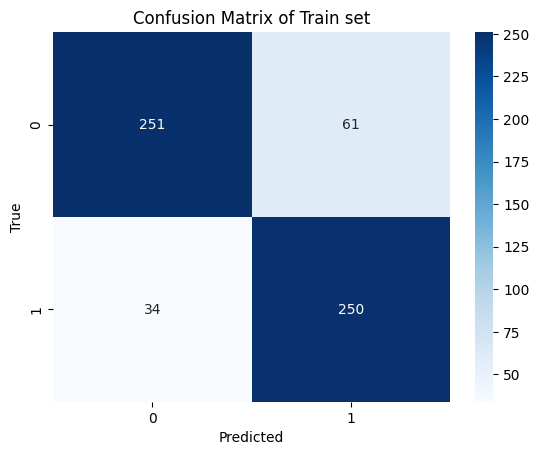

In [124]:
# Confusion matrix- Train set
cm_NBCbernoulli_train = confusion_matrix(y_train, y_train_NBCbernoulli_pred)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm_NBCbernoulli_train, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix of Train set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

From the confusion matrix we see that:
- 250 heart disease cases were correctly predicted out of 284 total. That gives a Recall of 0.880.
- 250 heart disease cases were correctly predicted out of 311 predicted cases as heart disease. That gives a Precision of 0.804.
- 501 instances were correctly predicted out of 596 total. That gives an Accuracy of 0.841.

These results are satisfactory. Bernoulli Naïve Bayes Classifier can now be tested and evaluated on a separate test set.

2. TESTING PHASE

First, we make predictions on the test set and print the Recall. 

In [125]:
# Predictions on test set
y_test_NBCbernoulli_pred = NBCbernoulli.predict(X_test)
test_recall = recall_score(y_test, y_test_NBCbernoulli_pred, average='binary')

print("Test set Recall: {:.3f}".format(test_recall))

Test set Recall: 0.903


We have a very satisfying Recall of 0.903 on the test set.

Next, we present the confusion matrix.

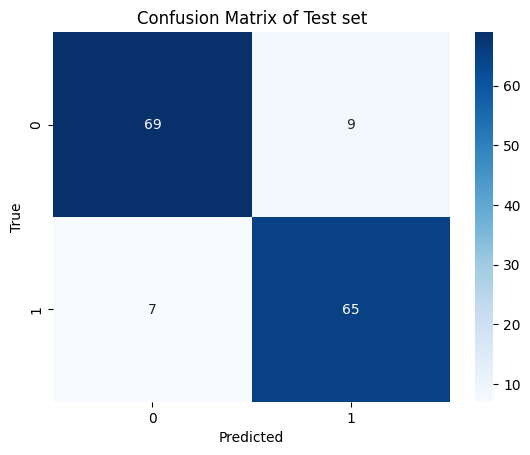

In [126]:
# Confusion matrix- Test set
cm_NBCbernoulli_test = confusion_matrix(y_test, y_test_NBCbernoulli_pred)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm_NBCbernoulli_test, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix of Test set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

As we see from the confusion matrix, the results are impressive. Now we present Classification Report to see all the evaluation metrics in depth. 

In [127]:
# Classification Report for NBC Bernoulli
print(classification_report(y_test, y_test_NBCbernoulli_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90        78
           1       0.88      0.90      0.89        72

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150



This classification report summarizes the performance of the of the Bernoulli Naïve Bayes Classifier model. Here's a breakdown of the key metrics:
- Precision:
    - For class 0 (no Heart Disease), precision is 0.91, which means that among the instances predicted as class 0, 91% of them are actually class 0.
    - For class 1 (Heart Disease), precision is 0.88, indicating that among the instances predicted as class 1, 88% of them are actually class 1.
- Recall:
    - For class 0, recall is 0.88, meaning that the model correctly identifies 88% of the instances belonging to class 0.
    - For class 1, recall is 0.90, indicating that the model correctly identifies 90% of the instances belonging to class 1.
- F1-score: 
    - For both classes 0 and 1, the F1-score is 0.88, suggesting a balanced performance in terms of precision and recall.
- Support:
    - For class 0, there are 78 instances, and for class 1, there are 72 instances in the test set.
- Accuracy: The overall accuracy of the model is 0.89, which means that 89% of the instances in the test set were correctly classified.
- Macro Avg: The macro average is the unweighted mean of precision, recall, and F1-score across all classes. In this case, it is 0.89.
- Weighted Avg: The weighted average considers the number of occurrences of each class during computation. It is the weighted mean of precision, recall, and F1-score across all classes. In this case, it is also 0.89.

Finally, we present the ROC curve.

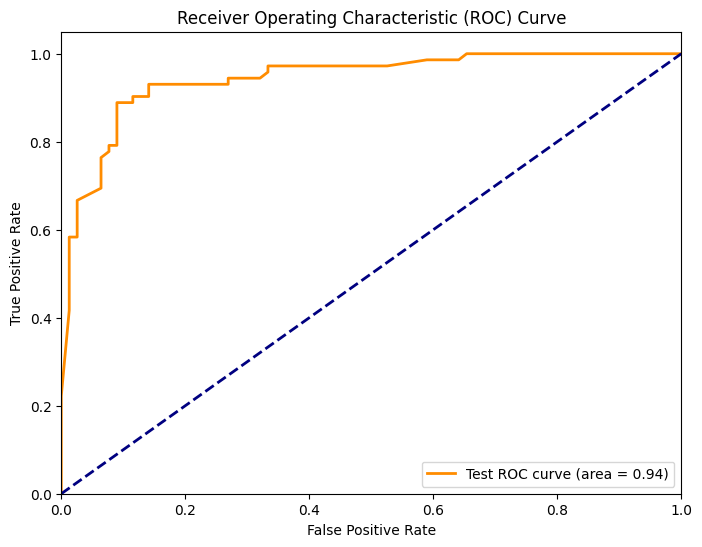

In [128]:
# ROC-AUC

# Get predicted probabilities
y_test_probs_NBCbernoulli = NBCbernoulli.predict_proba(X_test)[:, 1]

# Compute True and False Positive Rates
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs_NBCbernoulli)

# Compute Area Under the Curve (AUC)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='Test ROC curve (area = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

From this graph, we see that AUC is 0.94, which means there is a 94% chance that the model will be able to distinguish between positive class and negative class.

Overall, the Bernoulli Naïve Bayes Classifier model appears to perform quite well, achieving high precision, recall, and F1-scores for both classes, as well as a respectable overall accuracy of 89%. It seems to have balanced performance across the different metrics, indicating a reliable classification model. It also has an excellent separability as it yields an AUC score of 0.94. Finally, for the task at hand, the most important metric is Recall (True Positive Rate) which is equal to 0.90. Thus, the model can potentially capture 90 out of 100 heart disease cases.

### 3.2.8 Decision Trees - Data without scaling

1. TRAINING PHASE

In decision trees, errors stemming from overfitting or noisy data can lead to excessively large trees with unnecessary nodes and branches. To mitigate this issue, pruning techniques are employed to reduce the error rate by trimming the tree's scope, retaining only essential nodes and branches. In this section, we adopt pre-pruning, a technique that involves pruning the tree during its construction process.
Some important hyperparameters in the Decision Tree algorithm are:
1) criterion: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain.
2) max_depth: The Maximum depth in a decision tree is the number of nodes along the longest path from the root node down to the farthest leaf node. If none, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
3) min_samples_split: The minimum number of samples required to split and internal node. This parameter serves as a critical factor in regulating the tree's complexity and generalization ability. By setting a higher value for “min_samples_split”, the algorithm constructs simpler trees with fewer splits, which reduces the risk of overfitting to the training data. Conversely, lower values allow for more aggressive splitting, potentially capturing intricate patterns but increasing the likelihood of overfitting.
4) min_samples_leaf: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This ensures that the algorithm doesn't create leaf nodes with very few samples, which could lead to overfitting. Instead, it encourages the algorithm to create simpler trees with leaf nodes that have a minimum number of samples, thus promoting generalization and preventing the model from memorizing the noise in the training data
5) max_features: The number of features to consider when looking for the best split. By limiting the number of features considered, “max_features” prevents the tree from becoming overly complex, particularly in situations where there are many features available for splitting. This helps prevent the model from fitting noise in the data and improves its ability to generalize to unseen data.


Therefore, we employ Grid Search in conjunction with Cross Validation to determine the optimal values for these hyperparameters, to maximize the recall score and prevent overfitting.

In [129]:
# Apply GridSearchCV to find the optimal hyperparameters

# Set a random seed for reproducibility
np.random.seed(1)

# Create Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=1)

# Create space of candidate values
search_space_dt = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 2, 3, 4, 5, 6, 7, 8, 9, 10],     # Maximum depth of the tree. If none, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10],   # The minimum number of samples required to split an internal node
    "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], # The minimum number of samples required to be at a leaf node.
    'max_features': ['sqrt', 'log2', None]               # The number of features to consider when looking for the best split (mtry)
}

# Create grid search
grid_search_dt = GridSearchCV(
    dt_classifier, 
    param_grid=search_space_dt, 
    cv=5, 
    n_jobs=-1, 
    scoring=make_scorer(recall_score, greater_is_better=True)
)

# Fit the grid_search
grid_search_dt.fit(X_train, y_train)

# Get the best parameters
best_params_dt = grid_search_dt.best_params_ # best_params_dt variable contains a dictionary with the best hyperparameter values

# Evaluate the model on the training set
train_score_dt = grid_search_dt.score(X_train, y_train)

# Print the results
print("Best Parameters for Decision Tree:", best_params_dt)
print("Training Set Recall for Decision Tree): {:.3f}".format(train_score_dt))

Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2}
Training Set Recall for Decision Tree): 0.877


These hyperparameters values yield a training set recall of  0.877.

Next, we construct the Decision Tree model using these optimal values.

In [130]:
# Build the model

# Build the model using the best parameters found from GridSearchCV
dt = DecisionTreeClassifier(**best_params_dt) 
# The "**" operator is used to pass a dictionary of keyword arguments to a function or a constructor. 
# In this case, the constructor of the DecisionTreeClassifier class is being called, and the best hyperparameters 
# obtained from the grid search are passed as keyword arguments 

# Fit the model to the training data
dt.fit(X_train, y_train)

# Make predictions on the training set
y_train_dt_pred = dt.predict(X_train)
train_recall = recall_score(y_train, y_train_dt_pred, average='binary')

print("Train set Recall: {:.3f}".format(train_recall))

Train set Recall: 0.877


Now that we have built the model, we use a 5-fold cross validation to measure the performance in a more robust manner. 

In [131]:
# Cross Validation

k_fold = 5

# Use recall as the scoring metric
scorer = make_scorer(recall_score, average='binary')

# Perform cross-validation and obtain recall scores for each fold
scores = cross_val_score(dt, X_train, y_train, cv=k_fold, scoring=scorer)

# Print the recall for each fold
for fold, score in enumerate(scores):
    print(f"Fold {fold+1} recall: {score:.3f}")

# Calculate and print the average recall across all folds
average_recall = scores.mean()
print(f"Average recall: {average_recall:.3f}")

Fold 1 recall: 0.912
Fold 2 recall: 0.750
Fold 3 recall: 0.842
Fold 4 recall: 0.719
Fold 5 recall: 0.772
Average recall: 0.799


The cross-validation results display fluctuations in recall scores across different folds. The recall values range from 0.719 to 0.912 across the five folds. The average recall score of 0.799 suggests that the classifier performs moderately in terms of sensitivity to identifying true positive instances across the dataset. 

Next, we present a Confusion Matrix to visualize the results of the Decision Tree model. 

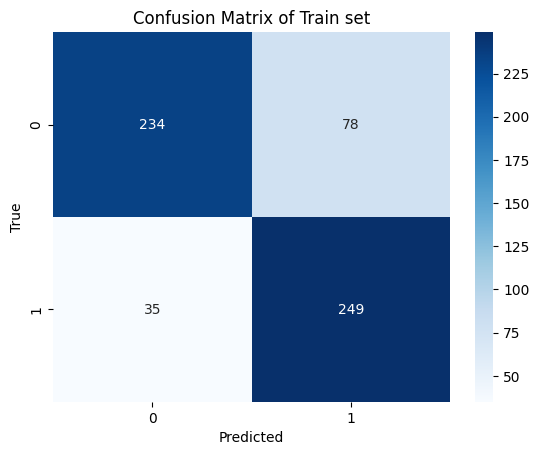

In [132]:
# Confusion matrix - Train set
cm_dt_train = confusion_matrix(y_train, y_train_dt_pred)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm_dt_train, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix of Train set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

From the confusion matrix we see that:
- 249 heart disease cases were correctly predicted out of 284 total. That gives a Recall of 0.877.
- 249 heart disease cases were correctly predicted out of 311 predicted cases as heart disease. That gives a Precision of 0.761.
- 483 instances were correctly predicted out of 596 total. That gives an Accuracy of 0.810.

These results are moderate. Now, the Decision Tree model is trained and ready to be tested and evaluated in our separate test set.

But, before we continue with testing the algorithm, we present the feature importance provided by the  Decision Tree model:

In [133]:
# Access feature importance
tree_feature_importances = dt.feature_importances_

# Create a DataFrame to display feature importance
tree_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': tree_feature_importances})
tree_feature_importance_df = tree_feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print("Feature Importances of The Decision Tree:")
print(tree_feature_importance_df)

Feature Importances of The Decision Tree:
              Feature  Importance
12   ExerciseAngina_Y    0.614723
13      ST_Slope_Flat    0.143241
5             Oldpeak    0.095468
0                 Age    0.060777
8   ChestPainType_NAP    0.030448
4               MaxHR    0.021480
2         Cholesterol    0.021392
1           RestingBP    0.012272
10  RestingECG_Normal    0.000200
3           FastingBS    0.000000
6               Sex_M    0.000000
7   ChestPainType_ATA    0.000000
9    ChestPainType_TA    0.000000
11      RestingECG_ST    0.000000
14        ST_Slope_Up    0.000000


We can see that Decision Tree model used only nine features. 

Next, we present a visualization of the Decision Tree.

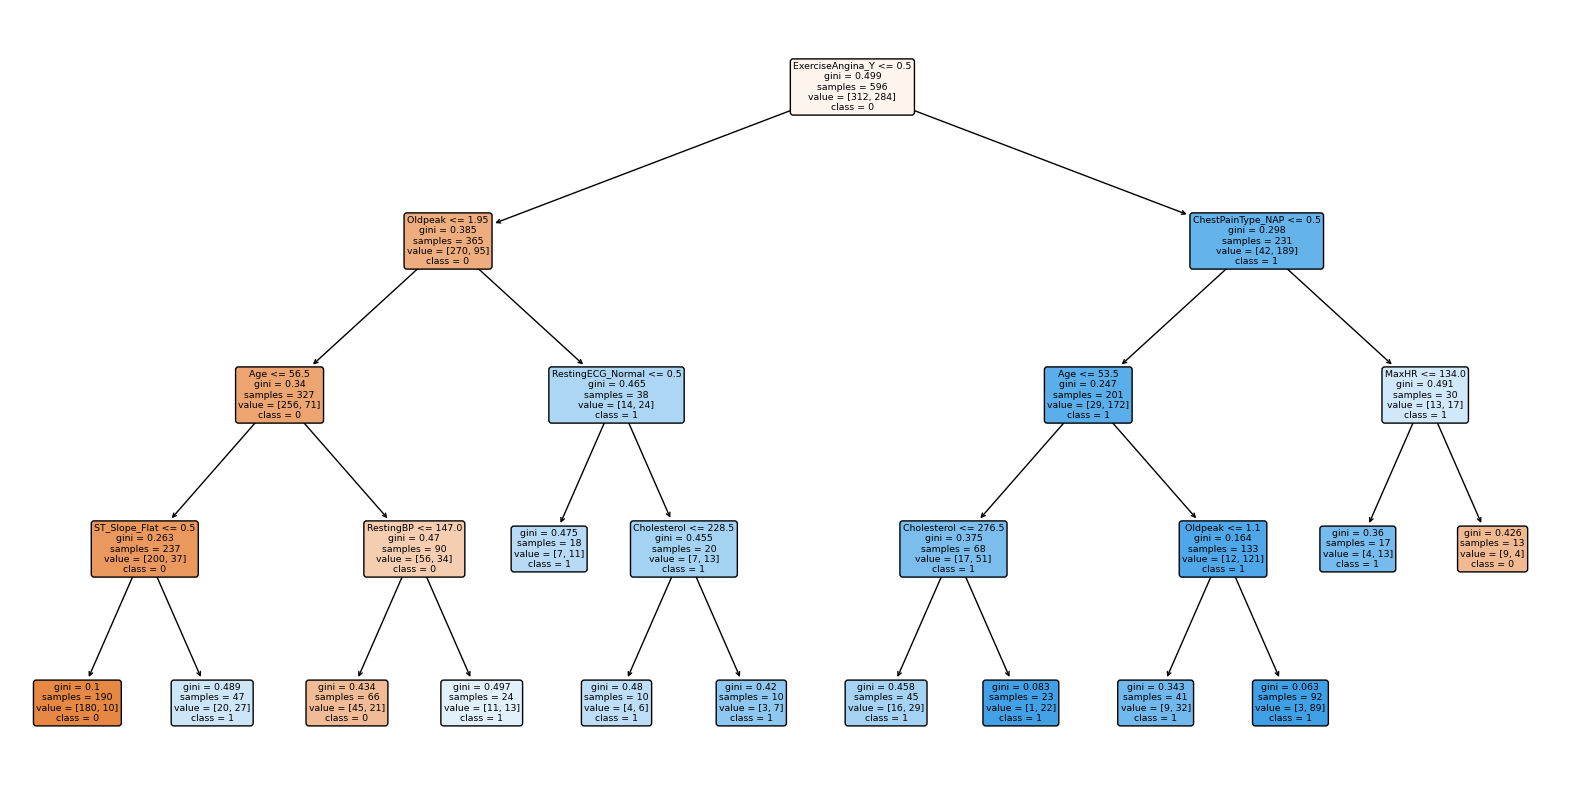

In [134]:
# Visualize the decision tree
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=X_train.columns, class_names=["0", "1"], filled=True, rounded=True)
plt.show()

From this graph, we see how the model make decisions.

2. TESTING PHASE

First, we make predictions on the test set and print the Recall.

In [135]:
# Make predictions on the test set
y_test_dt_pred = dt.predict(X_test)
test_recall = recall_score(y_test, y_test_dt_pred, average='binary')

print("Test set Recall: {:.3f}".format(test_recall))

Test set Recall: 0.875


We have a very decent Recall of 0.875 on the test set.

Next, we present the confusion matrix.

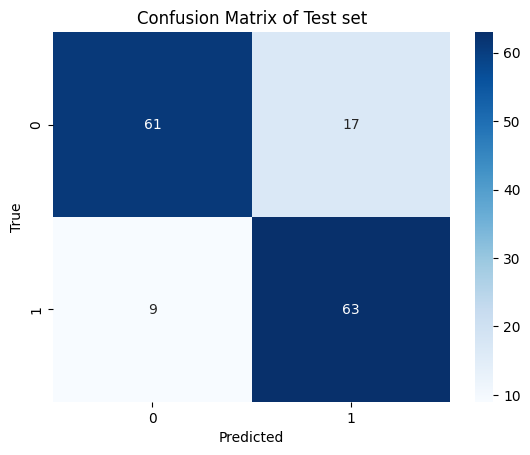

In [136]:
# Confusion matrix - Test set
cm_dt_test = confusion_matrix(y_test, y_test_dt_pred)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm_dt_test, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix of Test set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

As we see from the confusion matrix, the results are good. Now we present Classification Report to see all the evaluation metrics in depth. 

In [137]:
# Classification Report 
print(classification_report(y_test, y_test_dt_pred))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82        78
           1       0.79      0.88      0.83        72

    accuracy                           0.83       150
   macro avg       0.83      0.83      0.83       150
weighted avg       0.83      0.83      0.83       150



This classification report summarizes the performance of the of the Decision Tree model. Here's a breakdown of the key metrics:
- Precision:
    - For class 0 (no Heart Disease), precision is 0.87, which means that among the instances predicted as class 0, 87% of them are actually class 0.
    - For class 1 (Heart Disease), precision is 0.79, indicating that among the instances predicted as class 1, 79% of them are actually class 1.
- Recall:
    - For class 0, recall is 0.78, meaning that the model correctly identifies 78% of the instances belonging to class 0.
    - For class 1, recall is 0.88, indicating that the model correctly identifies 88% of the instances belonging to class 1.
- F1-score: 
    - For class 0, F1-score is 0.82, suggesting a balanced performance in terms of precision and recall.
    - For class 1, F1-score is 0.83, suggesting a balanced performance in terms of precision and recall.
- Support:
    - For class 0, there are 78 instances, and for class 1, there are 72 instances in the test set.
- Accuracy: The overall accuracy of the model is 0.83, which means that 83% of the instances in the test set were correctly classified.
- Macro Avg: The macro average is the unweighted mean of precision, recall, and F1-score across all classes. In this case, it is 0.83.
- Weighted Avg: The weighted average considers the number of occurrences of each class during computation. It is the weighted mean of precision, recall, and F1-score across all classes. In this case, it is also 0.83.

Finally, we present the ROC curve.

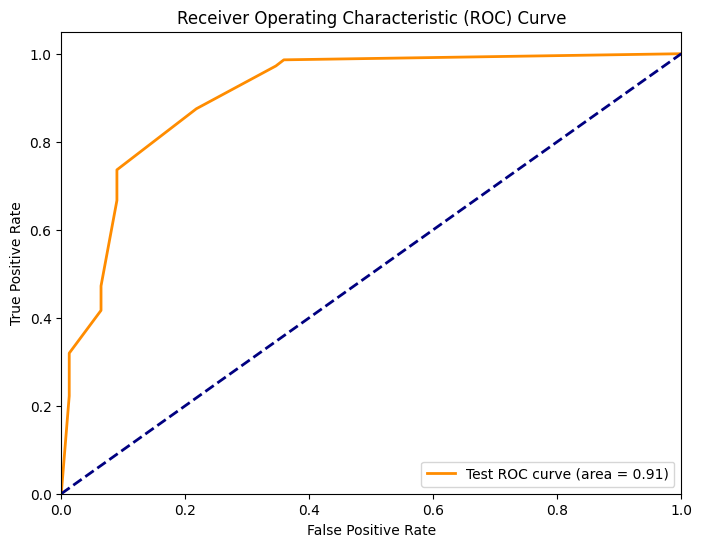

In [138]:
# ROC-AUC

# Get predicted probabilities
y_test_probs_dt = dt.predict_proba(X_test)[:, 1]

# Compute True and False Positive Rates
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs_dt)

# Compute Area Under the Curve (AUC)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='Test ROC curve (area = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

From this graph, we see that AUC is 0.91, which means there is a 91% chance that the model will be able to distinguish between positive class and negative class.

Overall, the Decision Tree model appears to perform decently, achieving moderate precision, recall, and F1-scores for both classes, as well as a respectable overall accuracy of 83%. It also has a satisfying separability as it yields an AUC score of 0.91. Finally, for the task at hand, the most important metric is Recall (True Positive Rate) which is equal to 0.88. Thus, the model can potentially capture 88 out of 100 heart disease cases.

### 3.3.9 Random Forest - Data without scaling

1. TRAINING PHASE

Some important hyperparameters in the Decision Tree algorithm are:
1. n_estimators: The number of trees in the forest.
2. max_depth: The maximum depth of the tree.
3. min_samples_split: The minimum number of samples required to split an internal node
4. min_samples_leaf: The minimum number of samples required to be at a leaf node.

Therefore, we employ Grid Search in conjunction with Cross Validation to determine the optimal values for these hyperparameters, to maximize the recall score and prevent overfitting.
Regarding the hyperparameters “criterion”  and “max_features”  we use the default values of scikit-learn's RandomForestClassifier.


In [139]:
# Apply GridSearchCV to find the optimal hyperparameters

# Set a random seed for reproducibility
np.random.seed(1) # because there is randomness in Random Forests algorithms

# Create RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=1)

# Create space of candidate values
search_space_rf = {
    'n_estimators': [50, 100, 125, 150], # The number of trees in the forest
    'max_depth': [5, 10, 20, 30],        # Maximum depth of the tree.
    'min_samples_split': [2, 5, 10, 15], # The minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3, 4]     # The minimum number of samples required to be at a leaf node.
}

# Create KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Create grid search
grid_search_rf = GridSearchCV(
    rf_classifier, param_grid=search_space_rf, cv=kfold, n_jobs=-1,
    scoring=make_scorer(recall_score, greater_is_better=True)
)

# Fit the grid_search
grid_search_rf.fit(X_train, y_train)

# Get the best parameters
best_params_rf = grid_search_rf.best_params_

# Evaluate the model on the training set
train_score_rf = grid_search_rf.score(X_train, y_train)

# Print the results
print("Best Parameters (Random Forest):", best_params_rf)
print("Training Set Recall (Random Forest): {:.3f}".format(train_score_rf))


Best Parameters (Random Forest): {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 50}
Training Set Recall (Random Forest): 0.901


These hyperparameters values yield a training set recall of  0.901.

Next, we construct the Decision Tree model using these optimal values. 

In [140]:
# Build the model
np.random.seed(1)

# # Build the model using the best parameters found from GridSearchCV
rf = RandomForestClassifier(**best_params_rf)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Make predictions on the training set
y_train_rf_pred = rf.predict(X_train)
train_recall = recall_score(y_train, y_train_rf_pred, average='binary')

print("Train set Recall: {:.3f}".format(train_recall))

Train set Recall: 0.901


Now that we have built the model, we use a 5-fold cross validation to measure the performance in more robust manner. 

In [141]:
# Cross Validation

k_fold = 5

# Use recall as the scoring metric
scorer = make_scorer(recall_score, average='binary')

# Perform cross-validation and obtain recall scores for each fold
scores = cross_val_score(rf, X_train, y_train, cv=k_fold, scoring=scorer)

# Print the recall for each fold
for fold, score in enumerate(scores):
    print(f"Fold {fold+1} recall: {score:.3f}")

# Calculate and print the average recall across all folds
average_recall = scores.mean()
print(f"Average recall: {average_recall:.3f}")

Fold 1 recall: 0.947
Fold 2 recall: 0.911
Fold 3 recall: 0.877
Fold 4 recall: 0.860
Fold 5 recall: 0.842
Average recall: 0.887


The recall scores across the folds do not vary significantly, indicating a stable performance of the model across different subsets of the data. The average recall score of 0.887 reflects the overall performance of the model across all folds. This indicates that, on average, the model successfully recalls approximately 88.7% of the positive instances in the dataset.

Finally, we visualize the performance of the trained Random Forest model through a confusion matrix. 

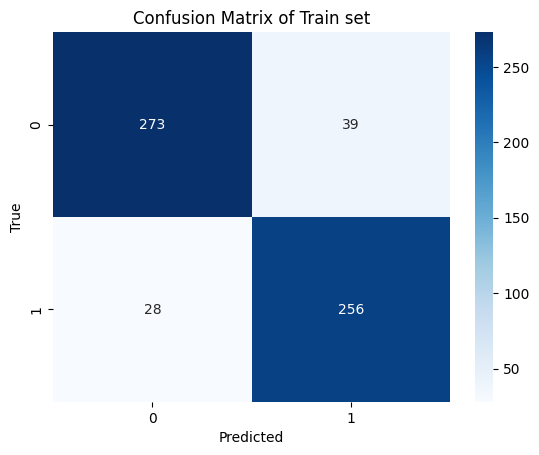

In [142]:
# Confusion matrix - Train set
cm_rf_train = confusion_matrix(y_train, y_train_rf_pred)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm_rf_train, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix of Train set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

From the confusion matrix we see that:
- 256 heart disease cases were correctly predicted out of 284 total. That gives a Recall of 0.901.
- 256 heart disease cases were correctly predicted out of 295 predicted cases as heart disease. That gives a Precision of 0.868.
- 529 instances were correctly predicted out of 596 total. That gives an Accuracy of 0.888.

These results are particularly encouraging, notably the high Recall, indicating our ability to capture a significant number of heart diseases accurately.

But, before we continue with testing the algorithm, below we present the feature importance provided by the  Random Forest model:

In [143]:
# Access feature importance
forest_feature_importances = rf.feature_importances_

# Create a DataFrame to display feature importance
forest_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': forest_feature_importances})
forest_feature_importance_df = forest_feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print(forest_feature_importance_df)

              Feature  Importance
14        ST_Slope_Up    0.197074
13      ST_Slope_Flat    0.171977
12   ExerciseAngina_Y    0.130449
5             Oldpeak    0.129380
4               MaxHR    0.092313
0                 Age    0.073614
7   ChestPainType_ATA    0.054711
6               Sex_M    0.047333
1           RestingBP    0.029137
2         Cholesterol    0.027132
8   ChestPainType_NAP    0.025149
10  RestingECG_Normal    0.009292
11      RestingECG_ST    0.004851
9    ChestPainType_TA    0.004466
3           FastingBS    0.003122


We can see that the features that seem to contribute the most are:
- ST_Slope_UP = 0.197074
- ST_Slope_Flat = 0.171977
- ExerciseAngina_Y = 0.130449

And the features the seem to contribute the least, are:
- RestingECG_ST = 0.004851
- ChestPainType_TA = 0.004466
- FastingBS = 0.003122

These findings are consistent with the previous analysis of feature importances (Point Biserial Correlation and Cramer’s V).

2. TESTING PHASE

First, we make predictions on the test set and print the Recall. 

In [144]:
# Make predictions on the test set
y_test_rf_pred = rf.predict(X_test)
test_recall = recall_score(y_test, y_test_rf_pred, average='binary')

print("Test set Recall: {:.3f}".format(test_recall))

Test set Recall: 0.903


We have a very satisfying Recall of 0.903 on the test set.

Next, we present the confusion matrix.

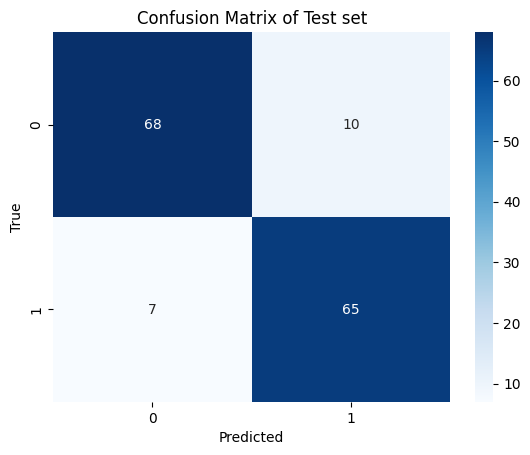

In [145]:
# Confusion matrix - Test set
cm_rf_test = confusion_matrix(y_test, y_test_rf_pred)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm_rf_test, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix of Test set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

As we see from the confusion matrix, the results are quite good. 

In [146]:
# Classification Report 
print(classification_report(y_test, y_test_rf_pred))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89        78
           1       0.87      0.90      0.88        72

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150



This classification report summarizes the performance of the of the Random Forest model. Here's a breakdown of the key metrics:
- Precision:
    - For class 0 (no Heart Disease), precision is 0.91, which means that among the instances predicted as class 0, 91% of them are actually class 0.
    - For class 1 (Heart Disease), precision is 0.87, indicating that among the instances predicted as class 1, 87% of them are actually class 1.
- Recall:
    - For class 0, recall is 0.87, meaning that the model correctly identifies 87% of the instances belonging to class 0.
    - For class 1, recall is 0.90, indicating that the model correctly identifies 90% of the instances belonging to class 1.
- F1-score: 
    - For class 0, F1-score is 0.89, suggesting a balanced performance in terms of precision and recall.
    - For class 1, F1-score is 0.88, suggesting a balanced performance in terms of precision and recall.
- Support:
- For class 0, there are 78 instances, and for class 1, there are 72 instances in the test set.
- Accuracy: The overall accuracy of the model is 0.89, which means that 89% of the instances in the test set were correctly classified.
- Macro Avg: The macro average is the unweighted mean of precision, recall, and F1-score across all classes. In this case, it is 0.89.
- Weighted Avg: The weighted average considers the number of occurrences of each class during computation. It is the weighted mean of precision, recall, and F1-score across all classes. In this case, it is also 0.89.

Finally, we present the ROC curve.

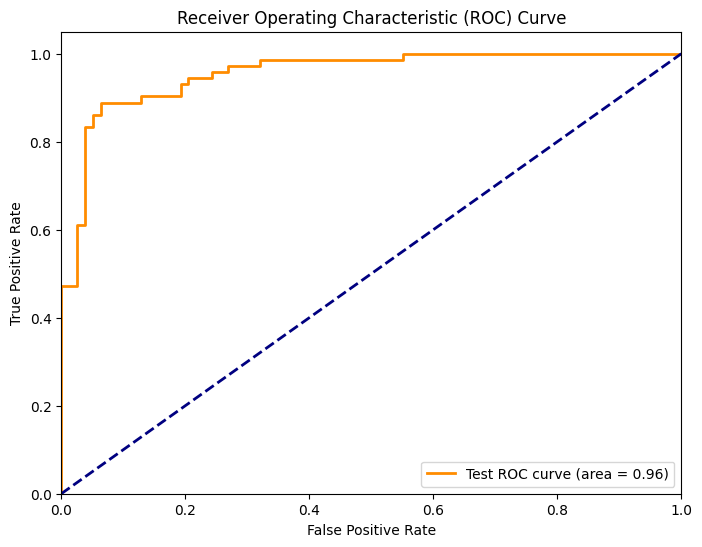

In [147]:
# ROC-AUC

# Get predicted probabilities
y_test_probs_rf = rf.predict_proba(X_test)[:, 1]

# Compute True and False Positive Rates
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs_rf)

# Compute Area Under the Curve (AUC)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='Test ROC curve (area = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

From this graph, we see that AUC is 0.96, which means there is a 96% chance that the model will be able to distinguish between positive class and negative class.

Overall, the Random Forest model appears to perform very well, achieving high precision, recall, and F1-scores for both classes, as well as an impressive overall accuracy of 89%. It seems to have balanced performance across the different metrics, indicating a reliable classification model. It also has an excellent separability as it yields an AUC score of 0.96. Finally, for the task at hand, the most important metric is Recall (True Positive Rate) which is equal to 0.90. Thus, the model can potentially capture 90 out of 100 heart disease cases.

# 4. FINAL REPORT

This section constitutes the culmination of our thesis. In Subsection 4.1, we undertake a comprehensive comparison across all models employed in our study. Following this analysis, Subsection 4.2 outlines the conclusions drawn from our findings, shedding light on key insights and implications derived from our research. Lastly, in Subsection 4.3, we propose recommendations for future research endeavors.

## 4.1 Model Comparison

First, we compare the key metrics of the training phase, namely Accuracy and Recall scores:

In [148]:
# Read the Excel file into a DataFrame
Training_Results = pd.read_excel("data/Comparison_of_Training_Results.xlsx", skiprows=1, index_col=0)

# Set the display format for float values
pd.options.display.float_format = '{:.3f}'.format

# Print Table
Training_Results

,kNN,Log Regression,Log. Regression - Threshold = 0.40,Naive Bayes Gaussian,Naïve Bayes Benoulli,Decision Tree,Random Forest
Accuracy,0.861,0.856,0.867,0.849,0.841,0.810,0.888
Recall (True Postive Rate),0.880,0.877,0.912,0.849,0.880,0.877,0.905


It appears that both “Logistic Regression with a modified threshold” and “Random Forest” algorithms exhibit strong performance in terms of accuracy and recall, with each excelling in different metrics. More specifically:
- Logistic Regression with a modified threshold achieves the highest recall score of 0.912, suggesting its effectiveness in identifying positive cases. It also achieves the second highest Accuracy of 0.867.
- Random Forest achieves the highest accuracy of 0.888, indicating its overall predictive power across both positive and negative cases. It also achieves the second highest Recall score of 0.901.


Then, we compare the cross-validation scores, to assess the robustness of each model:

In [149]:
# Read the Excel file into a DataFrame
Cross_Validation_Results = pd.read_excel("data/Comparison_of_CrossValidation_Results.xlsx", skiprows=1, index_col=0)

# Set the display format for float values
pd.options.display.float_format = '{:.3f}'.format

#Print Table
Cross_Validation_Results

,kNN,Log Regression,Naive Bayes Gaussian,Naïve Bayes Benoulli,Decision Tree,Random Forest
Fold 1,0.912,0.912,0.895,0.912,0.912,0.947
Fold 2,0.929,0.911,0.893,0.911,0.750,0.911
Fold 3,0.877,0.842,0.807,0.825,0.842,0.877
Fold 4,0.860,0.789,0.825,0.825,0.719,0.860
Fold 5,0.877,0.877,0.754,0.877,0.772,0.842
Average,0.891,0.866,0.835,0.870,0.799,0.887
Range,0.069,0.123,0.141,0.087,0.193,0.105
Standard Deviation,0.025,0.046,0.054,0.039,0.069,0.037


In the evaluation of cross-validation recall scores, we see that:
- The KNN algorithm demonstrates the best performance, boasting an average cross-validation recall score of 0.891, a range of 0.069 and a standard deviation of 0.025. This low variability across the five folds showcases the consistency of the algorithm, suggesting that it is robust.
- The Random Forest algorithm demonstrates the second-best performance, boasting an average cross-validation recall score of 0.888, a range of 0.105 and a standard deviation of 0.037. This low variability across the five folds showcases the consistency of the algorithm, suggesting that it is robust.


Lastly, we compare the testing scores to see how the trained models perform on unseen data:

In [150]:
# Read the Excel file into a DataFrame
Testing_Results = pd.read_excel("data/Comparison_of_Testing_Results.xlsx", skiprows=1, index_col=0)

# Set the display format for float values
pd.options.display.float_format = '{:.3f}'.format

#Print Table
Testing_Results

,kNN,Log Regression,Log Regression - Threshold = 0.40,Naive Bayes Gaussian,Naïve Bayes Benoulli,Decision Tree,Random Forest
Accuracy,0.893,0.900,0.880,0.913,0.894,0.827,0.887
Recall (True Positive Rate),0.917,0.889,0.917,0.917,0.903,0.875,0.903
Precision,0.868,0.901,0.846,0.904,0.878,0.788,0.867
F1 Score,0.892,0.895,0.880,0.911,0.890,0.829,0.885
AUC Score,0.930,0.950,0.880,0.960,0.940,0.910,0.960


In the evaluation of testing results, we see that:
- The "Naïve Bayes Gaussian" model exhibited slightly superior, or at least equal, performance compared to the other models across all metrics.
- Following closely behind were the "Random Forest", "kNN", and “Naïve Bayes Bernoulli” models, which demonstrated satisfactory scores in every metric, with notably high Recall scores.

While results on unseen data are crucial for assessing how algorithms generalize, we should also take into consideration the robustness of each model that we assessed from the analysis of cross-validation scores.

## 4.2 Conclusions

In this project, six classification algorithms were employed on a dataset that comprised of eleven features to predict whether a person has heart disease or not. The algorithms utilized include k Nearest Neighbors, Logistic Regression, Naïve Bayes Gaussian, Naive Bayes Bernoulli, Decision Tree, and Random Forest. Following exploratory data analysis and appropriate data preprocessing steps, the models were trained and tested on the aforementioned dataset, which was split in an 80-20 ratio, with 80% of the samples allocated for training and 20% for testing

The algorithms were trained and their hyperparameters were tuned with the purpose of maximizing the Recall score (True Positive Rate) because for the task at hand, the goal is to capture as many heart disease cases as possible, even if we have to sacrifice the overall accuracy of the algorithms.

Although the “Naïve Bayes Gaussian” model displayed the highest testing scores, i.e. an Accuracy score of 91.3%, an AUC score of 96.0%, an F1 score of 91.1%, and a Recall score of 91.7%, it exhibited mediocre cross-validation scores during the training phase. The model showed a moderate average Recall score of 83.5% and high variability across the five folds, with a range of 14.1% and a standard deviation of 5.4%. This instability indicates that the model lacks robustness.

In contrast the “Random Forest” and “kNN” models are more stable in overall performance. More specifically:
- The “Random Forest” model displayed high testing scores, i.e. an Accuracy score of 89.0%, an AUC score of 96.0%, an F1 score of 88.5% and a Recall score of 90.3%. Regarding cross-validation scores during the training phase, it displayed a high average recall score of 89.0% and low variability across the five folds, with a range of 10.5% and a standard deviation of 3.7%. This stability indicates that the model is robust across different datasets.
- Similar high testing results showcased the “kNN” model, i.e. an Accuracy score of 89.3%, AN AUC score of 93%, an F1 score of 89.2% and a Recall score of 91.7%. Regarding cross-validation scores during the training phase, it displayed a high average recall score of 89.1% and low variability across the five folds, with a range of 6.9% and a standard deviation of 2.5%. This stability indicates that the model is robust across different datasets.

## 4.3 Limitations and Recommendations for further research

In the correlation and association analysis conducted in section 2.5, certain features exhibit weaker associations with the target variable (Heart Disease). For instance, Cholesterol, Fasting Blood Sugar, and Resting Electrocardiogram Results demonstrated relatively lower associations, as evidenced by the lower values in Point Biserial Correlation for Cholesterol and Cramer’s V for Fasting Blood Sugar and Resting Electrocardiogram Results. These findings align with the internal feature importances derived from the following models:
- Logistic Regression model, as indicated by the coefficients.
- Decision Tree, through feature importance.
- Random Forest, through feature importance.

Considering these insights, one might consider feature reduction to explore how these models perform with fewer features. However, it's important to note that for effective feature engineering or reduction, domain expertise is crucial. 

Therefore, while the data analysis sheds light on potential features for reduction, the absence of domain expertise underscores the need for caution in implementing such strategies. Collaborating with medical professionals could provide invaluable insights into which features are truly indicative of heart disease and which are less relevant, enhancing the efficacy and validity of any feature reduction efforts.

Domain expertise is also crucial for handling missing values. For instance, in this dataset, 172 values are missing in the "Cholesterol" feature. By collaborating with medical experts, one can explore various imputation strategies such us knn imputation, mean imputation, linear regression, etc

Lastly, it is worth considering the exploration of alternative models such as Support Vector Machines or Neural Networks for heart disease classification. These models may offer distinct advantages in capturing complex patterns and relationships within the data. By complementing traditional methods like Decision Trees and Random Forests, Support Vector Machines or Neural Networks could provide additional perspectives on heart disease classification and potentially lead to more accurate models in clinical settings.

# THE END